In [1]:
import numpy as np
import os, sys
import tqdm
from tqdm import trange
from art.attacks.poisoning import GradientMatchingAttack
from art.utils import load_cifar10
from art.estimators.classification import PyTorchClassifier
from art.utils import to_categorical

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

/home/fabian/MasterStudium/PythonEnvironment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from art.utils import load_cifar10

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps does not work
print(device)

cuda


In [4]:
import timm

def _create_model(model_name, classes):
    model = timm.create_model(MODEL_NAME, pretrained=True) # TODO Consider pretrained=True and False
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, classes) # adapt final layer to match the 10 classes of CIFAR-10

    return model

MODEL_NAME = "resnet18.a1_in1k"
model = _create_model(MODEL_NAME, 10)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')   # 32 --> 224, Faktor 7
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True) # from poisoning example

loss_fn = torch.nn.CrossEntropyLoss()

In [5]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

x_train = np.transpose(x_train, [0, 3,1,2])
x_test = np.transpose(x_test, [0, 3,1,2])

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

print (mean, std)

0.4733630004850874 0.25156892506322026


In [6]:
def data_processing(x_train, y_train, x_test, y_test, upsampler, device=device):
    
    if upsampler is None:
        x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
        x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor

    else:
        _x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
        x_tensor = upsampler(_x_tensor)
        del _x_tensor

        _x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
        x_tensor_test = upsampler(_x_tensor_test)
        del _x_tensor_test

    y_train = np.argmax(y_train, axis=1)
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)

    y_test = np.argmax(y_test, axis=1)
    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    return x_tensor, y_tensor, x_tensor_test, y_tensor_test

In [7]:
x_train, y_train, x_test, y_test = data_processing(x_train, y_train, x_test, y_test, upsampler=None)


In [8]:
def _testAccuracy(model, test_loader, transform=None, max_steps=10):
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data

            if transform is not None:
                images = transform(images)

            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    if model_was_training:
      model.train()
    return(accuracy)

In [9]:
def train_model(model, optimizer, loss_fn, x_train, y_train, x_test, y_test, x_trigger=None, y_trigger=None, transform=None, batch_size=128, epochs=80):
    
    model.to(device)

    dataset_train = TensorDataset(x_train.to(device), y_train.to(device)) # create your datset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)

    dataset_test = TensorDataset(x_test.to(device), y_test.to(device)) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

    iter = trange(epochs)
    for _ in iter:
        running_loss = 0.0
        total = 0
        accuracy = 0
        for _, data in enumerate(dataloader_train, 0):
            inputs, labels = data
            optimizer.zero_grad()

            if transform is not None:
                outputs = model(transform(inputs))
            else:
                outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            running_loss += loss.item()
        train_accuracy = (accuracy / total)
        print ("train acc", train_accuracy)

        if x_trigger is not None:
            y_ = model(x_trigger)
            y_ = F.softmax(y_, dim=-1)[0]
            output_target = y_.detach().cpu().numpy()[y_trigger]
            iter.set_postfix({'acc': train_accuracy, 'target': output_target})
            tqdm.tqdm.write(str(output_target))
        else:
            iter.set_postfix({'acc': train_accuracy})
    test_accuracy = _testAccuracy(model, dataloader_test, transform)
    print("Final test accuracy: %f" % test_accuracy)

    del dataset_train, dataloader_train
    del dataset_test, dataloader_test

    return model


In [10]:
model_checkpoint_path = './state_dicts/poison_%s_cifar10_model_clean.pt' % MODEL_NAME
if os.path.isfile(model_checkpoint_path):
    checkpoint = torch.load(model_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])    
    print('loaded model checkpoint')
else:
    model = train_model(model, optimizer, loss_fn, x_train, y_train, x_test, y_test, transform=None, epochs=80)
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, model_checkpoint_path)
    print('saved model checkpoint')

print("Model and data preparation done.")

loaded model checkpoint
Model and data preparation done.


In [11]:
model = _create_model(MODEL_NAME, 10).cuda()

model_path = f"./state_dicts/poison_resnet18.a1_in1k_cifar10_model_clean.pt"
state_dict = torch.load(model_path)
model.load_state_dict(state_dict['model_state_dict'])

model.eval()

dataset_test = TensorDataset(x_test.to(device), y_test.to(device)) # create your datset
dataloader_test = DataLoader(dataset_test, batch_size=128)

acc = _testAccuracy(model=model, test_loader= dataloader_test)
print(f"Clean model Accuracy: {acc}")    

Clean model Accuracy: 73.9


In [12]:
x_train.shape

torch.Size([50000, 3, 32, 32])

#### Poison the Dataset

In [13]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack
def poison_data(model, x_trigger, y_trigger, max_epochs = 100):
    epsilson = (16/255)/std

    model_art = PyTorchClassifier(
        model=model,
        loss=loss_fn,
        optimizer=optimizer,    
        input_shape=x_train.shape[1:],
        nb_classes=10,
    ) 

    attack = GradientMatchingAttack(model_art,
            percent_poison=0.01,
            max_trials=1,
            max_epochs=max_epochs,
            clip_values=(min_,max_),
            learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
            epsilon=epsilson,
            verbose=1)

    x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train.cpu(), y_train.cpu())
    return torch.tensor(x_poison), torch.tensor(y_poison)

In [14]:
target_class = 1
source_class = 0
target_indices = np.where(y_test.cpu().numpy() == source_class)[0][:10]

x_trigger = x_test[target_indices]
y_trigger  = to_categorical([target_class], nb_classes=10)

In [15]:
import torch

x_poisons = []
y_poisons = []

for i in range(len(target_indices)):
    x_poison, y_poison = poison_data(model, x_trigger[i:i+1], y_trigger, max_epochs=500)
    x_poisons.append(x_poison)
    y_poisons.append(y_poison)

# Concatenate all the poisoned samples into a single tensor
x_poisons = torch.cat(x_poisons, dim=0)
y_poisons = torch.cat(y_poisons, dim=0)
torch.save((x_poisons, y_poisons), 'poisoned_data01.pt')

  0%|          | 0/1 [00:00<?, ?it/s]/home/fabian/MasterStudium/PythonEnvironment/lib/python3.10/site-packages/art/attacks/poisoning/gradient_matching_attack.py:343: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x_trigger, device=device, dtype=torch.float32),
100%|██████████| 1/1 [01:56<00:00, 116.89s/it]


Best B-score: 0.2600422


100%|██████████| 1/1 [02:05<00:00, 125.47s/it]


Best B-score: 0.27738336


100%|██████████| 1/1 [02:15<00:00, 135.89s/it]


Best B-score: 0.3525085


100%|██████████| 1/1 [02:23<00:00, 143.29s/it]


Best B-score: 0.28173503


100%|██████████| 1/1 [02:33<00:00, 153.77s/it]


Best B-score: 0.36280537


100%|██████████| 1/1 [02:39<00:00, 159.46s/it]


Best B-score: 0.3229082


100%|██████████| 1/1 [02:51<00:00, 171.40s/it]


Best B-score: 0.23892675


100%|██████████| 1/1 [02:53<00:00, 173.95s/it]


Best B-score: 0.2534315


100%|██████████| 1/1 [03:09<00:00, 189.17s/it]


Best B-score: 0.39951283


100%|██████████| 1/1 [03:18<00:00, 198.63s/it]


Best B-score: 0.3638148


In [16]:
x_poisons, y_poisons = torch.load('poisoned_data01.pt')

print("Poisoned data loaded successfully")

Poisoned data loaded successfully


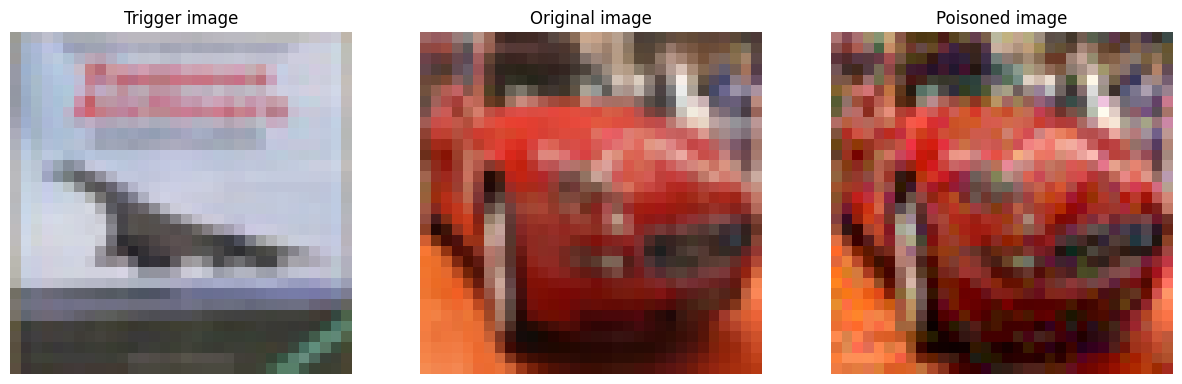

In [17]:
import matplotlib.pyplot as plt
# Identify the index of the poisoned example
index_poisoned_example = np.where([np.any(p != o) for (p, o) in zip(x_poison.cpu().numpy(), x_train.cpu().numpy())])[0]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the trigger image
axes[0].imshow(np.transpose(x_trigger.cpu().numpy()[0], (1, 2, 0)) * (std + 1e-7) + mean)
axes[0].set_title('Trigger image')
axes[0].axis('off')  # Hide the axis

# Display the original image
axes[1].imshow(np.transpose(x_train.cpu().numpy()[index_poisoned_example[0]], (1, 2, 0)) * (std + 1e-7) + mean)
axes[1].set_title('Original image')
axes[1].axis('off')  # Hide the axis

# Display the poisoned image
axes[2].imshow(np.transpose(x_poison.cpu().numpy()[index_poisoned_example[0]], (1, 2, 0)) * (std + 1e-7) + mean)
axes[2].set_title('Poisoned image')
axes[2].axis('off')  # Hide the axis

# Show the figure
plt.show()

#### Train poisoned Models

In [18]:
MODEL_NAME = "resnet18.a1_in1k"

for i in range(len(target_indices)):
    model_checkpoint_path = f'./state_dicts/poison_{MODEL_NAME}_cifar10_model_{i}01.pt'
    model = _create_model(MODEL_NAME, 10)
    upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')   # 32 --> 224, Faktor 7
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True) # from poisoning example
    loss_fn = torch.nn.CrossEntropyLoss()
    
    model = train_model(model, optimizer, loss_fn, x_poisons[50000*i:50000*(i + 1)], y_poisons[50000*i:50000*(i + 1)], x_test, y_test, transform=None, epochs=80)
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, model_checkpoint_path)
    print('saved model checkpoint')   

  1%|▏         | 1/80 [00:04<05:33,  4.22s/it, acc=0.568]

train acc 0.568


  2%|▎         | 2/80 [00:09<05:59,  4.61s/it, acc=0.738]

train acc 0.73768


  4%|▍         | 3/80 [00:13<06:03,  4.73s/it, acc=0.79] 

train acc 0.7899


  5%|▌         | 4/80 [00:18<06:05,  4.81s/it, acc=0.812]

train acc 0.81208


  6%|▋         | 5/80 [00:23<06:04,  4.86s/it, acc=0.829]

train acc 0.82872


  8%|▊         | 6/80 [00:27<05:16,  4.27s/it, acc=0.833]

train acc 0.83276


  9%|▉         | 7/80 [00:30<04:53,  4.02s/it, acc=0.839]

train acc 0.83914


 10%|█         | 8/80 [00:34<04:38,  3.87s/it, acc=0.842]

train acc 0.84232


 11%|█▏        | 9/80 [00:37<04:25,  3.74s/it, acc=0.84] 

train acc 0.8399


 12%|█▎        | 10/80 [00:41<04:16,  3.67s/it, acc=0.845]

train acc 0.84474


 14%|█▍        | 11/80 [00:44<04:07,  3.59s/it, acc=0.848]

train acc 0.84752


 15%|█▌        | 12/80 [00:47<03:59,  3.52s/it, acc=0.852]

train acc 0.85174


 16%|█▋        | 13/80 [00:51<03:57,  3.55s/it, acc=0.856]

train acc 0.8562


 18%|█▊        | 14/80 [00:55<03:55,  3.57s/it, acc=0.859]

train acc 0.85866


 19%|█▉        | 15/80 [00:58<03:52,  3.57s/it, acc=0.863]

train acc 0.8626


 20%|██        | 16/80 [01:02<03:50,  3.59s/it, acc=0.865]

train acc 0.86548


 21%|██▏       | 17/80 [01:05<03:38,  3.46s/it, acc=0.87] 

train acc 0.8704


 22%|██▎       | 18/80 [01:08<03:27,  3.35s/it, acc=0.873]

train acc 0.8728


 24%|██▍       | 19/80 [01:12<03:27,  3.40s/it, acc=0.875]

train acc 0.87534


 25%|██▌       | 20/80 [01:16<03:45,  3.75s/it, acc=0.876]

train acc 0.87552


 26%|██▋       | 21/80 [01:20<03:38,  3.70s/it, acc=0.879]

train acc 0.87884


 28%|██▊       | 22/80 [01:23<03:29,  3.62s/it, acc=0.882]

train acc 0.88232


 29%|██▉       | 23/80 [01:26<03:21,  3.54s/it, acc=0.884]

train acc 0.88408


 30%|███       | 24/80 [01:30<03:16,  3.52s/it, acc=0.884]

train acc 0.88404


 31%|███▏      | 25/80 [01:33<03:11,  3.49s/it, acc=0.884]

train acc 0.88372


 32%|███▎      | 26/80 [01:37<03:09,  3.52s/it, acc=0.888]

train acc 0.88772


 34%|███▍      | 27/80 [01:40<03:03,  3.47s/it, acc=0.888]

train acc 0.8881


 35%|███▌      | 28/80 [01:44<02:59,  3.44s/it, acc=0.89] 

train acc 0.88972


 36%|███▋      | 29/80 [01:47<02:56,  3.46s/it, acc=0.889]

train acc 0.88938


 38%|███▊      | 30/80 [01:51<02:54,  3.48s/it, acc=0.891]

train acc 0.8909


 39%|███▉      | 31/80 [01:54<02:50,  3.47s/it, acc=0.894]

train acc 0.89354


 40%|████      | 32/80 [01:58<02:47,  3.50s/it, acc=0.892]

train acc 0.89182


 41%|████▏     | 33/80 [02:01<02:45,  3.51s/it, acc=0.894]

train acc 0.89434


 42%|████▎     | 34/80 [02:05<02:41,  3.50s/it, acc=0.898]

train acc 0.89812


 44%|████▍     | 35/80 [02:08<02:31,  3.36s/it, acc=0.894]

train acc 0.894


 45%|████▌     | 36/80 [02:11<02:23,  3.26s/it, acc=0.896]

train acc 0.89648


 46%|████▋     | 37/80 [02:14<02:20,  3.26s/it, acc=0.897]

train acc 0.89676


 48%|████▊     | 38/80 [02:18<02:21,  3.36s/it, acc=0.9]  

train acc 0.8999


 49%|████▉     | 39/80 [02:21<02:18,  3.37s/it, acc=0.896]

train acc 0.89612


 50%|█████     | 40/80 [02:24<02:10,  3.27s/it, acc=0.899]

train acc 0.89948


 51%|█████▏    | 41/80 [02:27<02:03,  3.17s/it, acc=0.898]

train acc 0.89818


 52%|█████▎    | 42/80 [02:30<02:03,  3.24s/it, acc=0.9]  

train acc 0.89976


 54%|█████▍    | 43/80 [02:33<01:58,  3.19s/it, acc=0.898]

train acc 0.89838


 55%|█████▌    | 44/80 [02:37<01:56,  3.24s/it, acc=0.901]

train acc 0.90078


 56%|█████▋    | 45/80 [02:40<01:54,  3.28s/it, acc=0.901]

train acc 0.90128


 57%|█████▊    | 46/80 [02:44<01:52,  3.32s/it, acc=0.9]  

train acc 0.9


 59%|█████▉    | 47/80 [02:47<01:49,  3.32s/it, acc=0.9]

train acc 0.9004


 60%|██████    | 48/80 [02:51<01:49,  3.41s/it, acc=0.897]

train acc 0.89706


 61%|██████▏   | 49/80 [02:54<01:47,  3.46s/it, acc=0.9]  

train acc 0.89976


 62%|██████▎   | 50/80 [02:57<01:42,  3.41s/it, acc=0.903]

train acc 0.90288


 64%|██████▍   | 51/80 [03:01<01:40,  3.45s/it, acc=0.902]

train acc 0.90226


 65%|██████▌   | 52/80 [03:05<01:37,  3.49s/it, acc=0.901]

train acc 0.90088


 66%|██████▋   | 53/80 [03:08<01:34,  3.52s/it, acc=0.902]

train acc 0.90154


 68%|██████▊   | 54/80 [03:13<01:37,  3.77s/it, acc=0.903]

train acc 0.90296


 69%|██████▉   | 55/80 [03:17<01:38,  3.93s/it, acc=0.897]

train acc 0.8974


 70%|███████   | 56/80 [03:22<01:41,  4.24s/it, acc=0.902]

train acc 0.90212


 71%|███████▏  | 57/80 [03:26<01:39,  4.31s/it, acc=0.904]

train acc 0.9041


 72%|███████▎  | 58/80 [03:30<01:33,  4.24s/it, acc=0.904]

train acc 0.9037


 74%|███████▍  | 59/80 [03:33<01:21,  3.89s/it, acc=0.902]

train acc 0.90244


 75%|███████▌  | 60/80 [03:37<01:15,  3.79s/it, acc=0.904]

train acc 0.90426


 76%|███████▋  | 61/80 [03:40<01:10,  3.69s/it, acc=0.902]

train acc 0.90242


 78%|███████▊  | 62/80 [03:44<01:05,  3.66s/it, acc=0.904]

train acc 0.9037


 79%|███████▉  | 63/80 [03:48<01:01,  3.64s/it, acc=0.903]

train acc 0.90264


 80%|████████  | 64/80 [03:51<00:58,  3.64s/it, acc=0.903]

train acc 0.90284


 81%|████████▏ | 65/80 [03:55<00:54,  3.64s/it, acc=0.903]

train acc 0.90278


 82%|████████▎ | 66/80 [03:59<00:50,  3.63s/it, acc=0.904]

train acc 0.90402


 84%|████████▍ | 67/80 [04:02<00:47,  3.62s/it, acc=0.904]

train acc 0.9038


 85%|████████▌ | 68/80 [04:06<00:43,  3.62s/it, acc=0.903]

train acc 0.90288


 86%|████████▋ | 69/80 [04:09<00:38,  3.47s/it, acc=0.904]

train acc 0.90384


 88%|████████▊ | 70/80 [04:12<00:34,  3.46s/it, acc=0.904]

train acc 0.90432


 89%|████████▉ | 71/80 [04:16<00:31,  3.49s/it, acc=0.903]

train acc 0.90266


 90%|█████████ | 72/80 [04:19<00:27,  3.42s/it, acc=0.904]

train acc 0.90364


 91%|█████████▏| 73/80 [04:22<00:23,  3.38s/it, acc=0.907]

train acc 0.90658


 92%|█████████▎| 74/80 [04:26<00:20,  3.41s/it, acc=0.902]

train acc 0.90222


 94%|█████████▍| 75/80 [04:29<00:17,  3.47s/it, acc=0.905]

train acc 0.90468


 95%|█████████▌| 76/80 [04:33<00:14,  3.53s/it, acc=0.908]

train acc 0.90792


 96%|█████████▋| 77/80 [04:37<00:10,  3.56s/it, acc=0.907]

train acc 0.90708


 98%|█████████▊| 78/80 [04:40<00:07,  3.52s/it, acc=0.905]

train acc 0.9048


 99%|█████████▉| 79/80 [04:44<00:03,  3.49s/it, acc=0.904]

train acc 0.90364


100%|██████████| 80/80 [04:47<00:00,  3.59s/it, acc=0.905]

train acc 0.90462
Final test accuracy: 74.270000


saved model checkpoint


  1%|▏         | 1/80 [00:03<04:43,  3.59s/it, acc=0.561]

train acc 0.56134


  2%|▎         | 2/80 [00:07<04:38,  3.58s/it, acc=0.736]

train acc 0.7359


  4%|▍         | 3/80 [00:10<04:35,  3.58s/it, acc=0.787]

train acc 0.78704


  5%|▌         | 4/80 [00:14<04:31,  3.57s/it, acc=0.811]

train acc 0.81076


  6%|▋         | 5/80 [00:17<04:29,  3.59s/it, acc=0.826]

train acc 0.82616


  8%|▊         | 6/80 [00:21<04:25,  3.59s/it, acc=0.833]

train acc 0.83322


  9%|▉         | 7/80 [00:25<04:21,  3.59s/it, acc=0.837]

train acc 0.8369


 10%|█         | 8/80 [00:28<04:19,  3.60s/it, acc=0.839]

train acc 0.83874


 11%|█▏        | 9/80 [00:32<04:12,  3.55s/it, acc=0.844]

train acc 0.84436


 12%|█▎        | 10/80 [00:35<04:09,  3.57s/it, acc=0.848]

train acc 0.84768


 14%|█▍        | 11/80 [00:39<04:07,  3.59s/it, acc=0.849]

train acc 0.8488


 15%|█▌        | 12/80 [00:43<04:04,  3.60s/it, acc=0.853]

train acc 0.85312


 16%|█▋        | 13/80 [00:46<04:02,  3.61s/it, acc=0.854]

train acc 0.85382


 18%|█▊        | 14/80 [00:50<03:54,  3.55s/it, acc=0.858]

train acc 0.85752


 19%|█▉        | 15/80 [00:53<03:41,  3.41s/it, acc=0.861]

train acc 0.86138


 20%|██        | 16/80 [00:56<03:32,  3.31s/it, acc=0.867]

train acc 0.86652


 21%|██▏       | 17/80 [00:59<03:24,  3.25s/it, acc=0.871]

train acc 0.87086


 22%|██▎       | 18/80 [01:02<03:22,  3.27s/it, acc=0.873]

train acc 0.87288


 24%|██▍       | 19/80 [01:06<03:25,  3.37s/it, acc=0.875]

train acc 0.87536


 25%|██▌       | 20/80 [01:09<03:21,  3.36s/it, acc=0.875]

train acc 0.87518


 26%|██▋       | 21/80 [01:12<03:12,  3.27s/it, acc=0.879]

train acc 0.87916


 28%|██▊       | 22/80 [01:15<03:06,  3.21s/it, acc=0.883]

train acc 0.88286


 29%|██▉       | 23/80 [01:18<03:01,  3.19s/it, acc=0.883]

train acc 0.88262


 30%|███       | 24/80 [01:22<03:04,  3.29s/it, acc=0.887]

train acc 0.88682


 31%|███▏      | 25/80 [01:26<03:07,  3.41s/it, acc=0.886]

train acc 0.88624


 32%|███▎      | 26/80 [01:29<03:09,  3.50s/it, acc=0.886]

train acc 0.8864


 34%|███▍      | 27/80 [01:33<03:08,  3.56s/it, acc=0.89] 

train acc 0.88972


 35%|███▌      | 28/80 [01:37<03:05,  3.57s/it, acc=0.891]

train acc 0.89128


 36%|███▋      | 29/80 [01:40<03:02,  3.57s/it, acc=0.89] 

train acc 0.89


 38%|███▊      | 30/80 [01:44<02:58,  3.56s/it, acc=0.892]

train acc 0.8922


 39%|███▉      | 31/80 [01:47<02:52,  3.52s/it, acc=0.891]

train acc 0.89118


 40%|████      | 32/80 [01:50<02:44,  3.42s/it, acc=0.894]

train acc 0.89398


 41%|████▏     | 33/80 [01:53<02:34,  3.29s/it, acc=0.896]

train acc 0.89578


 42%|████▎     | 34/80 [01:56<02:26,  3.19s/it, acc=0.894]

train acc 0.89386


 44%|████▍     | 35/80 [01:59<02:20,  3.13s/it, acc=0.895]

train acc 0.8955


 45%|████▌     | 36/80 [02:02<02:16,  3.10s/it, acc=0.897]

train acc 0.89656


 46%|████▋     | 37/80 [02:05<02:12,  3.08s/it, acc=0.896]

train acc 0.89586


 48%|████▊     | 38/80 [02:08<02:08,  3.06s/it, acc=0.898]

train acc 0.89804


 49%|████▉     | 39/80 [02:11<02:04,  3.05s/it, acc=0.896]

train acc 0.89572


 50%|█████     | 40/80 [02:15<02:04,  3.12s/it, acc=0.899]

train acc 0.89916


 51%|█████▏    | 41/80 [02:18<02:07,  3.26s/it, acc=0.898]

train acc 0.89826


 52%|█████▎    | 42/80 [02:22<02:07,  3.37s/it, acc=0.899]

train acc 0.89938


 54%|█████▍    | 43/80 [02:25<02:07,  3.45s/it, acc=0.898]

train acc 0.89752


 55%|█████▌    | 44/80 [02:30<02:19,  3.88s/it, acc=0.896]

train acc 0.89608


 56%|█████▋    | 45/80 [02:35<02:25,  4.17s/it, acc=0.901]

train acc 0.90108


 57%|█████▊    | 46/80 [02:40<02:25,  4.29s/it, acc=0.899]

train acc 0.89916


 59%|█████▉    | 47/80 [02:43<02:13,  4.04s/it, acc=0.901]

train acc 0.9009


 60%|██████    | 48/80 [02:47<02:05,  3.92s/it, acc=0.901]

train acc 0.9015


 61%|██████▏   | 49/80 [02:51<01:58,  3.83s/it, acc=0.9]  

train acc 0.89958


 62%|██████▎   | 50/80 [02:54<01:53,  3.77s/it, acc=0.9]

train acc 0.89988


 64%|██████▍   | 51/80 [02:58<01:47,  3.72s/it, acc=0.9]

train acc 0.89998


 65%|██████▌   | 52/80 [03:01<01:43,  3.71s/it, acc=0.9]

train acc 0.89986


 66%|██████▋   | 53/80 [03:05<01:39,  3.67s/it, acc=0.902]

train acc 0.9022


 68%|██████▊   | 54/80 [03:09<01:35,  3.67s/it, acc=0.905]

train acc 0.90472


 69%|██████▉   | 55/80 [03:12<01:31,  3.67s/it, acc=0.902]

train acc 0.90218


 70%|███████   | 56/80 [03:16<01:28,  3.67s/it, acc=0.901]

train acc 0.90144


 71%|███████▏  | 57/80 [03:20<01:24,  3.65s/it, acc=0.901]

train acc 0.9007


 72%|███████▎  | 58/80 [03:23<01:20,  3.65s/it, acc=0.904]

train acc 0.90442


 74%|███████▍  | 59/80 [03:27<01:16,  3.64s/it, acc=0.903]

train acc 0.90294


 75%|███████▌  | 60/80 [03:31<01:12,  3.63s/it, acc=0.903]

train acc 0.90282


 76%|███████▋  | 61/80 [03:34<01:09,  3.63s/it, acc=0.903]

train acc 0.9028


 78%|███████▊  | 62/80 [03:38<01:04,  3.60s/it, acc=0.904]

train acc 0.9041


 79%|███████▉  | 63/80 [03:41<01:01,  3.60s/it, acc=0.905]

train acc 0.90454


 80%|████████  | 64/80 [03:45<00:57,  3.57s/it, acc=0.901]

train acc 0.90076


 81%|████████▏ | 65/80 [03:48<00:52,  3.53s/it, acc=0.903]

train acc 0.90262


 82%|████████▎ | 66/80 [03:52<00:48,  3.49s/it, acc=0.904]

train acc 0.9045


 84%|████████▍ | 67/80 [03:55<00:45,  3.47s/it, acc=0.904]

train acc 0.90424


 85%|████████▌ | 68/80 [03:58<00:41,  3.46s/it, acc=0.905]

train acc 0.90528


 86%|████████▋ | 69/80 [04:02<00:37,  3.45s/it, acc=0.905]

train acc 0.90486


 88%|████████▊ | 70/80 [04:05<00:34,  3.42s/it, acc=0.905]

train acc 0.90498


 89%|████████▉ | 71/80 [04:09<00:31,  3.46s/it, acc=0.905]

train acc 0.9049


 90%|█████████ | 72/80 [04:12<00:28,  3.52s/it, acc=0.904]

train acc 0.90438


 91%|█████████▏| 73/80 [04:16<00:24,  3.55s/it, acc=0.902]

train acc 0.90206


 92%|█████████▎| 74/80 [04:20<00:21,  3.53s/it, acc=0.906]

train acc 0.90634


 94%|█████████▍| 75/80 [04:23<00:17,  3.49s/it, acc=0.904]

train acc 0.90414


 95%|█████████▌| 76/80 [04:26<00:13,  3.48s/it, acc=0.904]

train acc 0.90414


 96%|█████████▋| 77/80 [04:30<00:10,  3.45s/it, acc=0.908]

train acc 0.90762


 98%|█████████▊| 78/80 [04:33<00:06,  3.45s/it, acc=0.906]

train acc 0.90562


 99%|█████████▉| 79/80 [04:36<00:03,  3.39s/it, acc=0.906]

train acc 0.90556


100%|██████████| 80/80 [04:40<00:00,  3.50s/it, acc=0.905]

train acc 0.9046


Final test accuracy: 73.210000
saved model checkpoint


  1%|▏         | 1/80 [00:03<04:42,  3.57s/it, acc=0.56]

train acc 0.56004


  2%|▎         | 2/80 [00:06<04:29,  3.45s/it, acc=0.738]

train acc 0.73798


  4%|▍         | 3/80 [00:10<04:26,  3.46s/it, acc=0.79] 

train acc 0.78966


  5%|▌         | 4/80 [00:13<04:24,  3.48s/it, acc=0.815]

train acc 0.81462


  6%|▋         | 5/80 [00:17<04:23,  3.51s/it, acc=0.827]

train acc 0.82716


  8%|▊         | 6/80 [00:20<04:16,  3.46s/it, acc=0.834]

train acc 0.8344


  9%|▉         | 7/80 [00:24<04:10,  3.43s/it, acc=0.838]

train acc 0.83802


 10%|█         | 8/80 [00:27<04:07,  3.44s/it, acc=0.84] 

train acc 0.83978


 11%|█▏        | 9/80 [00:31<04:05,  3.45s/it, acc=0.843]

train acc 0.84342


 12%|█▎        | 10/80 [00:34<04:00,  3.43s/it, acc=0.848]

train acc 0.84824


 14%|█▍        | 11/80 [00:38<04:13,  3.67s/it, acc=0.848]

train acc 0.84776


 15%|█▌        | 12/80 [00:43<04:36,  4.07s/it, acc=0.852]

train acc 0.85178


 16%|█▋        | 13/80 [00:48<04:50,  4.33s/it, acc=0.855]

train acc 0.85466


 18%|█▊        | 14/80 [00:52<04:31,  4.11s/it, acc=0.861]

train acc 0.86122


 19%|█▉        | 15/80 [00:55<04:16,  3.95s/it, acc=0.86] 

train acc 0.8599


 20%|██        | 16/80 [00:59<04:06,  3.85s/it, acc=0.866]

train acc 0.8659


 21%|██▏       | 17/80 [01:02<03:55,  3.74s/it, acc=0.868]

train acc 0.86768


 22%|██▎       | 18/80 [01:07<04:02,  3.91s/it, acc=0.872]

train acc 0.8716


 24%|██▍       | 19/80 [01:10<03:50,  3.78s/it, acc=0.874]

train acc 0.87354


 25%|██▌       | 20/80 [01:14<03:41,  3.68s/it, acc=0.877]

train acc 0.87708


 26%|██▋       | 21/80 [01:17<03:31,  3.59s/it, acc=0.876]

train acc 0.87622


 28%|██▊       | 22/80 [01:21<03:30,  3.63s/it, acc=0.884]

train acc 0.88436


 29%|██▉       | 23/80 [01:24<03:26,  3.62s/it, acc=0.881]

train acc 0.88132


 30%|███       | 24/80 [01:28<03:21,  3.61s/it, acc=0.881]

train acc 0.88054


 31%|███▏      | 25/80 [01:32<03:18,  3.60s/it, acc=0.886]

train acc 0.88618


 32%|███▎      | 26/80 [01:35<03:11,  3.55s/it, acc=0.886]

train acc 0.8865


 34%|███▍      | 27/80 [01:38<03:04,  3.47s/it, acc=0.888]

train acc 0.88764


 35%|███▌      | 28/80 [01:42<02:59,  3.45s/it, acc=0.888]

train acc 0.88818


 36%|███▋      | 29/80 [01:45<02:55,  3.45s/it, acc=0.892]

train acc 0.89226


 38%|███▊      | 30/80 [01:49<02:54,  3.49s/it, acc=0.893]

train acc 0.89268


 39%|███▉      | 31/80 [01:52<02:54,  3.55s/it, acc=0.892]

train acc 0.89216


 40%|████      | 32/80 [01:56<02:51,  3.58s/it, acc=0.892]

train acc 0.89244


 41%|████▏     | 33/80 [02:00<02:48,  3.59s/it, acc=0.895]

train acc 0.89452


 42%|████▎     | 34/80 [02:03<02:45,  3.60s/it, acc=0.892]

train acc 0.89244


 44%|████▍     | 35/80 [02:07<02:42,  3.61s/it, acc=0.898]

train acc 0.89794


 45%|████▌     | 36/80 [02:12<02:55,  3.99s/it, acc=0.896]

train acc 0.89574


 46%|████▋     | 37/80 [02:16<02:57,  4.14s/it, acc=0.896]

train acc 0.8957


 48%|████▊     | 38/80 [02:20<02:51,  4.08s/it, acc=0.899]

train acc 0.89892


 49%|████▉     | 39/80 [02:24<02:41,  3.94s/it, acc=0.898]

train acc 0.89758


 50%|█████     | 40/80 [02:27<02:30,  3.77s/it, acc=0.898]

train acc 0.89776


 51%|█████▏    | 41/80 [02:31<02:24,  3.70s/it, acc=0.896]

train acc 0.8961


 52%|█████▎    | 42/80 [02:34<02:19,  3.68s/it, acc=0.898]

train acc 0.89788


 54%|█████▍    | 43/80 [02:38<02:15,  3.65s/it, acc=0.895]

train acc 0.89504


 55%|█████▌    | 44/80 [02:42<02:12,  3.67s/it, acc=0.897]

train acc 0.8968


 56%|█████▋    | 45/80 [02:45<02:08,  3.66s/it, acc=0.902]

train acc 0.90166


 57%|█████▊    | 46/80 [02:49<02:03,  3.65s/it, acc=0.901]

train acc 0.90128


 59%|█████▉    | 47/80 [02:53<02:00,  3.65s/it, acc=0.897]

train acc 0.8975


 60%|██████    | 48/80 [02:57<02:06,  3.94s/it, acc=0.902]

train acc 0.90166


 61%|██████▏   | 49/80 [03:01<02:00,  3.87s/it, acc=0.903]

train acc 0.90294


 62%|██████▎   | 50/80 [03:05<01:54,  3.83s/it, acc=0.902]

train acc 0.90216


 64%|██████▍   | 51/80 [03:08<01:50,  3.80s/it, acc=0.899]

train acc 0.89866


 65%|██████▌   | 52/80 [03:12<01:45,  3.77s/it, acc=0.902]

train acc 0.90212


 66%|██████▋   | 53/80 [03:16<01:40,  3.72s/it, acc=0.901]

train acc 0.90136


 68%|██████▊   | 54/80 [03:19<01:35,  3.68s/it, acc=0.903]

train acc 0.9031


 69%|██████▉   | 55/80 [03:23<01:31,  3.66s/it, acc=0.904]

train acc 0.90408


 70%|███████   | 56/80 [03:27<01:28,  3.67s/it, acc=0.901]

train acc 0.90096


 71%|███████▏  | 57/80 [03:30<01:23,  3.63s/it, acc=0.903]

train acc 0.90266


 72%|███████▎  | 58/80 [03:34<01:18,  3.58s/it, acc=0.904]

train acc 0.90356


 74%|███████▍  | 59/80 [03:37<01:14,  3.53s/it, acc=0.899]

train acc 0.89928


 75%|███████▌  | 60/80 [03:40<01:07,  3.37s/it, acc=0.903]

train acc 0.9031


 76%|███████▋  | 61/80 [03:43<01:01,  3.26s/it, acc=0.902]

train acc 0.90226


 78%|███████▊  | 62/80 [03:47<01:00,  3.35s/it, acc=0.903]

train acc 0.90326


 79%|███████▉  | 63/80 [03:50<00:58,  3.44s/it, acc=0.901]

train acc 0.90108


 80%|████████  | 64/80 [03:54<00:56,  3.51s/it, acc=0.903]

train acc 0.90286


 81%|████████▏ | 65/80 [03:58<00:53,  3.55s/it, acc=0.904]

train acc 0.90422


 82%|████████▎ | 66/80 [04:01<00:49,  3.56s/it, acc=0.903]

train acc 0.90296


 84%|████████▍ | 67/80 [04:05<00:46,  3.57s/it, acc=0.905]

train acc 0.90514


 85%|████████▌ | 68/80 [04:08<00:43,  3.59s/it, acc=0.907]

train acc 0.9069


 86%|████████▋ | 69/80 [04:12<00:39,  3.59s/it, acc=0.905]

train acc 0.90464


 88%|████████▊ | 70/80 [04:16<00:35,  3.59s/it, acc=0.902]

train acc 0.90248


 89%|████████▉ | 71/80 [04:19<00:32,  3.60s/it, acc=0.904]

train acc 0.90398


 90%|█████████ | 72/80 [04:23<00:28,  3.58s/it, acc=0.906]

train acc 0.90594


 91%|█████████▏| 73/80 [04:26<00:25,  3.60s/it, acc=0.904]

train acc 0.90418


 92%|█████████▎| 74/80 [04:30<00:21,  3.60s/it, acc=0.903]

train acc 0.9034


 94%|█████████▍| 75/80 [04:34<00:18,  3.61s/it, acc=0.906]

train acc 0.90558


 95%|█████████▌| 76/80 [04:37<00:14,  3.61s/it, acc=0.904]

train acc 0.90404


 96%|█████████▋| 77/80 [04:41<00:10,  3.61s/it, acc=0.907]

train acc 0.9067


 98%|█████████▊| 78/80 [04:44<00:07,  3.61s/it, acc=0.902]

train acc 0.90156


 99%|█████████▉| 79/80 [04:48<00:03,  3.55s/it, acc=0.905]

train acc 0.90516


100%|██████████| 80/80 [04:51<00:00,  3.64s/it, acc=0.903]

train acc 0.903


Final test accuracy: 73.780000
saved model checkpoint


  1%|▏         | 1/80 [00:03<04:43,  3.59s/it, acc=0.571]

train acc 0.57128


  2%|▎         | 2/80 [00:06<04:23,  3.37s/it, acc=0.735]

train acc 0.7346


  4%|▍         | 3/80 [00:10<04:15,  3.32s/it, acc=0.786]

train acc 0.78646


  5%|▌         | 4/80 [00:13<04:17,  3.39s/it, acc=0.813]

train acc 0.81256


  6%|▋         | 5/80 [00:17<04:15,  3.41s/it, acc=0.826]

train acc 0.82574


  8%|▊         | 6/80 [00:20<04:14,  3.43s/it, acc=0.835]

train acc 0.83474


  9%|▉         | 7/80 [00:23<04:07,  3.40s/it, acc=0.838]

train acc 0.83846


 10%|█         | 8/80 [00:27<03:59,  3.33s/it, acc=0.837]

train acc 0.83748


 11%|█▏        | 9/80 [00:30<03:59,  3.37s/it, acc=0.843]

train acc 0.8431


 12%|█▎        | 10/80 [00:33<03:57,  3.40s/it, acc=0.846]

train acc 0.84634


 14%|█▍        | 11/80 [00:37<03:58,  3.45s/it, acc=0.848]

train acc 0.84794


 15%|█▌        | 12/80 [00:41<03:58,  3.51s/it, acc=0.851]

train acc 0.85112


 16%|█▋        | 13/80 [00:44<03:54,  3.50s/it, acc=0.856]

train acc 0.85564


 18%|█▊        | 14/80 [00:47<03:44,  3.41s/it, acc=0.854]

train acc 0.85444


 19%|█▉        | 15/80 [00:51<03:42,  3.42s/it, acc=0.86] 

train acc 0.8596


 20%|██        | 16/80 [00:54<03:38,  3.42s/it, acc=0.864]

train acc 0.86444


 21%|██▏       | 17/80 [00:57<03:32,  3.37s/it, acc=0.868]

train acc 0.86826


 22%|██▎       | 18/80 [01:01<03:32,  3.43s/it, acc=0.871]

train acc 0.87064


 24%|██▍       | 19/80 [01:04<03:30,  3.45s/it, acc=0.875]

train acc 0.87492


 25%|██▌       | 20/80 [01:07<03:19,  3.32s/it, acc=0.878]

train acc 0.87784


 26%|██▋       | 21/80 [01:11<03:16,  3.33s/it, acc=0.88] 

train acc 0.88028


 28%|██▊       | 22/80 [01:14<03:15,  3.37s/it, acc=0.879]

train acc 0.87908


 29%|██▉       | 23/80 [01:18<03:15,  3.44s/it, acc=0.881]

train acc 0.88116


 30%|███       | 24/80 [01:21<03:14,  3.48s/it, acc=0.883]

train acc 0.88332


 31%|███▏      | 25/80 [01:25<03:13,  3.51s/it, acc=0.888]

train acc 0.88796


 32%|███▎      | 26/80 [01:29<03:13,  3.58s/it, acc=0.889]

train acc 0.88882


 34%|███▍      | 27/80 [01:32<03:07,  3.53s/it, acc=0.887]

train acc 0.88712


 35%|███▌      | 28/80 [01:36<03:01,  3.48s/it, acc=0.889]

train acc 0.88928


 36%|███▋      | 29/80 [01:39<02:55,  3.44s/it, acc=0.892]

train acc 0.89242


 38%|███▊      | 30/80 [01:42<02:47,  3.36s/it, acc=0.893]

train acc 0.89266


 39%|███▉      | 31/80 [01:46<02:45,  3.39s/it, acc=0.893]

train acc 0.89316


 40%|████      | 32/80 [01:49<02:45,  3.45s/it, acc=0.892]

train acc 0.8925


 41%|████▏     | 33/80 [01:53<02:45,  3.51s/it, acc=0.891]

train acc 0.89138


 42%|████▎     | 34/80 [01:56<02:37,  3.42s/it, acc=0.896]

train acc 0.8961


 44%|████▍     | 35/80 [02:00<02:36,  3.47s/it, acc=0.897]

train acc 0.89692


 45%|████▌     | 36/80 [02:03<02:34,  3.51s/it, acc=0.896]

train acc 0.89552


 46%|████▋     | 37/80 [02:07<02:32,  3.55s/it, acc=0.896]

train acc 0.8961


 48%|████▊     | 38/80 [02:10<02:28,  3.52s/it, acc=0.896]

train acc 0.89584


 49%|████▉     | 39/80 [02:15<02:36,  3.81s/it, acc=0.899]

train acc 0.89886


 50%|█████     | 40/80 [02:20<02:45,  4.14s/it, acc=0.898]

train acc 0.89766


 51%|█████▏    | 41/80 [02:24<02:41,  4.14s/it, acc=0.9]  

train acc 0.90006


 52%|█████▎    | 42/80 [02:29<02:44,  4.34s/it, acc=0.9]

train acc 0.89982


 54%|█████▍    | 43/80 [02:34<02:46,  4.50s/it, acc=0.9]

train acc 0.90002


 55%|█████▌    | 44/80 [02:37<02:36,  4.34s/it, acc=0.898]

train acc 0.89836


 56%|█████▋    | 45/80 [02:41<02:24,  4.14s/it, acc=0.899]

train acc 0.89942


 57%|█████▊    | 46/80 [02:45<02:16,  4.00s/it, acc=0.9]  

train acc 0.9004


 59%|█████▉    | 47/80 [02:48<02:08,  3.90s/it, acc=0.902]

train acc 0.90196


 60%|██████    | 48/80 [02:52<02:02,  3.83s/it, acc=0.904]

train acc 0.90398


 61%|██████▏   | 49/80 [02:56<01:56,  3.77s/it, acc=0.899]

train acc 0.8995


 62%|██████▎   | 50/80 [02:59<01:52,  3.75s/it, acc=0.901]

train acc 0.90068


 64%|██████▍   | 51/80 [03:03<01:47,  3.72s/it, acc=0.901]

train acc 0.90106


 65%|██████▌   | 52/80 [03:08<01:55,  4.11s/it, acc=0.902]

train acc 0.90222


 66%|██████▋   | 53/80 [03:13<01:53,  4.21s/it, acc=0.904]

train acc 0.9037


 68%|██████▊   | 54/80 [03:17<01:47,  4.14s/it, acc=0.903]

train acc 0.90296


 69%|██████▉   | 55/80 [03:20<01:40,  4.01s/it, acc=0.9]  

train acc 0.89978


 70%|███████   | 56/80 [03:24<01:33,  3.90s/it, acc=0.904]

train acc 0.90368


 71%|███████▏  | 57/80 [03:28<01:27,  3.82s/it, acc=0.904]

train acc 0.90372


 72%|███████▎  | 58/80 [03:31<01:20,  3.67s/it, acc=0.9]  

train acc 0.89984


 74%|███████▍  | 59/80 [03:34<01:15,  3.60s/it, acc=0.903]

train acc 0.90306


 75%|███████▌  | 60/80 [03:38<01:10,  3.51s/it, acc=0.904]

train acc 0.90366


 76%|███████▋  | 61/80 [03:41<01:05,  3.44s/it, acc=0.907]

train acc 0.9069


 78%|███████▊  | 62/80 [03:44<01:01,  3.44s/it, acc=0.903]

train acc 0.90326


 79%|███████▉  | 63/80 [03:48<00:58,  3.45s/it, acc=0.9]  

train acc 0.90048


 80%|████████  | 64/80 [03:51<00:55,  3.49s/it, acc=0.905]

train acc 0.90456


 81%|████████▏ | 65/80 [03:55<00:52,  3.51s/it, acc=0.903]

train acc 0.90308


 82%|████████▎ | 66/80 [03:58<00:48,  3.48s/it, acc=0.906]

train acc 0.90622


 84%|████████▍ | 67/80 [04:02<00:44,  3.44s/it, acc=0.904]

train acc 0.90432


 85%|████████▌ | 68/80 [04:05<00:40,  3.41s/it, acc=0.905]

train acc 0.90512


 86%|████████▋ | 69/80 [04:08<00:37,  3.39s/it, acc=0.905]

train acc 0.90488


 88%|████████▊ | 70/80 [04:12<00:33,  3.39s/it, acc=0.906]

train acc 0.9061


 89%|████████▉ | 71/80 [04:15<00:30,  3.43s/it, acc=0.905]

train acc 0.90458


 90%|█████████ | 72/80 [04:19<00:27,  3.46s/it, acc=0.905]

train acc 0.90522


 91%|█████████▏| 73/80 [04:22<00:24,  3.49s/it, acc=0.904]

train acc 0.90432


 92%|█████████▎| 74/80 [04:26<00:20,  3.49s/it, acc=0.904]

train acc 0.90376


 94%|█████████▍| 75/80 [04:29<00:17,  3.49s/it, acc=0.901]

train acc 0.90114


 95%|█████████▌| 76/80 [04:33<00:13,  3.48s/it, acc=0.904]

train acc 0.90438


 96%|█████████▋| 77/80 [04:36<00:10,  3.49s/it, acc=0.906]

train acc 0.9056


 98%|█████████▊| 78/80 [04:40<00:07,  3.51s/it, acc=0.906]

train acc 0.90588


 99%|█████████▉| 79/80 [04:43<00:03,  3.37s/it, acc=0.904]

train acc 0.90366


100%|██████████| 80/80 [04:46<00:00,  3.58s/it, acc=0.905]

train acc 0.90498
Final test accuracy: 72.610000


saved model checkpoint


  1%|▏         | 1/80 [00:03<04:41,  3.56s/it, acc=0.568]

train acc 0.5679


  2%|▎         | 2/80 [00:06<04:30,  3.47s/it, acc=0.739]

train acc 0.73896


  4%|▍         | 3/80 [00:10<04:29,  3.50s/it, acc=0.791]

train acc 0.79146


  5%|▌         | 4/80 [00:14<04:28,  3.54s/it, acc=0.814]

train acc 0.81416


  6%|▋         | 5/80 [00:17<04:27,  3.56s/it, acc=0.827]

train acc 0.8271


  8%|▊         | 6/80 [00:21<04:24,  3.57s/it, acc=0.834]

train acc 0.83426


  9%|▉         | 7/80 [00:24<04:22,  3.59s/it, acc=0.839]

train acc 0.83892


 10%|█         | 8/80 [00:28<04:15,  3.55s/it, acc=0.841]

train acc 0.84138


 11%|█▏        | 9/80 [00:31<04:09,  3.52s/it, acc=0.842]

train acc 0.84234


 12%|█▎        | 10/80 [00:35<04:04,  3.50s/it, acc=0.849]

train acc 0.84876


 14%|█▍        | 11/80 [00:38<03:50,  3.34s/it, acc=0.851]

train acc 0.85132


 15%|█▌        | 12/80 [00:41<03:39,  3.23s/it, acc=0.853]

train acc 0.8525


 16%|█▋        | 13/80 [00:44<03:34,  3.21s/it, acc=0.853]

train acc 0.85332


 18%|█▊        | 14/80 [00:47<03:32,  3.21s/it, acc=0.86] 

train acc 0.86022


 19%|█▉        | 15/80 [00:51<03:32,  3.26s/it, acc=0.862]

train acc 0.86228


 20%|██        | 16/80 [00:54<03:31,  3.30s/it, acc=0.865]

train acc 0.86548


 21%|██▏       | 17/80 [00:57<03:22,  3.21s/it, acc=0.869]

train acc 0.86872


 22%|██▎       | 18/80 [01:00<03:15,  3.15s/it, acc=0.87] 

train acc 0.87032


 24%|██▍       | 19/80 [01:03<03:08,  3.10s/it, acc=0.875]

train acc 0.87494


 25%|██▌       | 20/80 [01:06<03:08,  3.14s/it, acc=0.875]

train acc 0.87536


 26%|██▋       | 21/80 [01:10<03:13,  3.28s/it, acc=0.877]

train acc 0.87672


 28%|██▊       | 22/80 [01:13<03:15,  3.38s/it, acc=0.882]

train acc 0.88196


 29%|██▉       | 23/80 [01:17<03:17,  3.47s/it, acc=0.884]

train acc 0.88418


 30%|███       | 24/80 [01:21<03:17,  3.52s/it, acc=0.883]

train acc 0.88344


 31%|███▏      | 25/80 [01:25<03:19,  3.62s/it, acc=0.888]

train acc 0.88758


 32%|███▎      | 26/80 [01:29<03:26,  3.82s/it, acc=0.886]

train acc 0.88632


 34%|███▍      | 27/80 [01:32<03:12,  3.64s/it, acc=0.887]

train acc 0.88686


 35%|███▌      | 28/80 [01:36<03:07,  3.61s/it, acc=0.89] 

train acc 0.8902


 36%|███▋      | 29/80 [01:39<03:03,  3.60s/it, acc=0.889]

train acc 0.88854


 38%|███▊      | 30/80 [01:43<03:00,  3.62s/it, acc=0.894]

train acc 0.89392


 39%|███▉      | 31/80 [01:46<02:57,  3.62s/it, acc=0.893]

train acc 0.89262


 40%|████      | 32/80 [01:50<02:50,  3.56s/it, acc=0.895]

train acc 0.89526


 41%|████▏     | 33/80 [01:53<02:44,  3.49s/it, acc=0.892]

train acc 0.89216


 42%|████▎     | 34/80 [01:57<02:39,  3.46s/it, acc=0.895]

train acc 0.89454


 44%|████▍     | 35/80 [02:00<02:34,  3.42s/it, acc=0.894]

train acc 0.89364


 45%|████▌     | 36/80 [02:03<02:31,  3.45s/it, acc=0.901]

train acc 0.90102


 46%|████▋     | 37/80 [02:07<02:25,  3.37s/it, acc=0.897]

train acc 0.89682


 48%|████▊     | 38/80 [02:10<02:20,  3.34s/it, acc=0.894]

train acc 0.894


 49%|████▉     | 39/80 [02:13<02:18,  3.38s/it, acc=0.895]

train acc 0.89482


 50%|█████     | 40/80 [02:17<02:15,  3.40s/it, acc=0.9]  

train acc 0.9005


 51%|█████▏    | 41/80 [02:20<02:11,  3.37s/it, acc=0.897]

train acc 0.89664


 52%|█████▎    | 42/80 [02:24<02:09,  3.40s/it, acc=0.898]

train acc 0.89836


 54%|█████▍    | 43/80 [02:27<02:06,  3.41s/it, acc=0.897]

train acc 0.89728


 55%|█████▌    | 44/80 [02:31<02:04,  3.45s/it, acc=0.899]

train acc 0.8994


 56%|█████▋    | 45/80 [02:34<02:03,  3.52s/it, acc=0.9]  

train acc 0.90004


 57%|█████▊    | 46/80 [02:38<02:00,  3.55s/it, acc=0.899]

train acc 0.89878


 59%|█████▉    | 47/80 [02:42<01:58,  3.60s/it, acc=0.902]

train acc 0.90174


 60%|██████    | 48/80 [02:45<01:55,  3.61s/it, acc=0.9]  

train acc 0.90046


 61%|██████▏   | 49/80 [02:49<01:49,  3.54s/it, acc=0.901]

train acc 0.90098


 62%|██████▎   | 50/80 [02:52<01:41,  3.40s/it, acc=0.9]  

train acc 0.90048


 64%|██████▍   | 51/80 [02:55<01:38,  3.39s/it, acc=0.9]

train acc 0.89964


 65%|██████▌   | 52/80 [02:59<01:36,  3.45s/it, acc=0.899]

train acc 0.89906


 66%|██████▋   | 53/80 [03:02<01:34,  3.48s/it, acc=0.899]

train acc 0.89914


 68%|██████▊   | 54/80 [03:06<01:31,  3.51s/it, acc=0.902]

train acc 0.90212


 69%|██████▉   | 55/80 [03:09<01:28,  3.54s/it, acc=0.903]

train acc 0.90298


 70%|███████   | 56/80 [03:13<01:24,  3.52s/it, acc=0.9]  

train acc 0.90028


 71%|███████▏  | 57/80 [03:16<01:20,  3.50s/it, acc=0.9]

train acc 0.90042


 72%|███████▎  | 58/80 [03:20<01:15,  3.43s/it, acc=0.904]

train acc 0.90356


 74%|███████▍  | 59/80 [03:22<01:09,  3.29s/it, acc=0.902]

train acc 0.90152


 75%|███████▌  | 60/80 [03:26<01:05,  3.27s/it, acc=0.9]  

train acc 0.89992


 76%|███████▋  | 61/80 [03:29<01:03,  3.32s/it, acc=0.901]

train acc 0.90102


 78%|███████▊  | 62/80 [03:32<00:58,  3.23s/it, acc=0.9]  

train acc 0.90004


 79%|███████▉  | 63/80 [03:35<00:54,  3.20s/it, acc=0.902]

train acc 0.90214


 80%|████████  | 64/80 [03:38<00:50,  3.16s/it, acc=0.902]

train acc 0.90216


 81%|████████▏ | 65/80 [03:42<00:48,  3.21s/it, acc=0.903]

train acc 0.9032


 82%|████████▎ | 66/80 [03:45<00:44,  3.19s/it, acc=0.903]

train acc 0.90288


 84%|████████▍ | 67/80 [03:48<00:41,  3.21s/it, acc=0.906]

train acc 0.90564


 85%|████████▌ | 68/80 [03:52<00:40,  3.34s/it, acc=0.903]

train acc 0.90274


 86%|████████▋ | 69/80 [03:55<00:37,  3.45s/it, acc=0.905]

train acc 0.9046


 88%|████████▊ | 70/80 [03:59<00:35,  3.52s/it, acc=0.904]

train acc 0.90378


 89%|████████▉ | 71/80 [04:03<00:31,  3.53s/it, acc=0.904]

train acc 0.90438


 90%|█████████ | 72/80 [04:06<00:28,  3.55s/it, acc=0.904]

train acc 0.90424


 91%|█████████▏| 73/80 [04:10<00:24,  3.50s/it, acc=0.903]

train acc 0.90296


 92%|█████████▎| 74/80 [04:14<00:22,  3.69s/it, acc=0.904]

train acc 0.9045


 94%|█████████▍| 75/80 [04:17<00:17,  3.58s/it, acc=0.904]

train acc 0.90418


 95%|█████████▌| 76/80 [04:20<00:13,  3.43s/it, acc=0.905]

train acc 0.90518


 96%|█████████▋| 77/80 [04:23<00:10,  3.38s/it, acc=0.905]

train acc 0.90502


 98%|█████████▊| 78/80 [04:27<00:06,  3.38s/it, acc=0.907]

train acc 0.90692


 99%|█████████▉| 79/80 [04:30<00:03,  3.41s/it, acc=0.906]

train acc 0.90588


100%|██████████| 80/80 [04:34<00:00,  3.43s/it, acc=0.905]

train acc 0.90488


Final test accuracy: 72.860000
saved model checkpoint


  1%|▏         | 1/80 [00:03<04:42,  3.57s/it, acc=0.561]

train acc 0.56094


  2%|▎         | 2/80 [00:07<04:38,  3.57s/it, acc=0.737]

train acc 0.73682


  4%|▍         | 3/80 [00:10<04:33,  3.55s/it, acc=0.79] 

train acc 0.7896


  5%|▌         | 4/80 [00:14<04:29,  3.55s/it, acc=0.814]

train acc 0.8138


  6%|▋         | 5/80 [00:17<04:25,  3.54s/it, acc=0.827]

train acc 0.82726


  8%|▊         | 6/80 [00:21<04:20,  3.51s/it, acc=0.833]

train acc 0.83326


  9%|▉         | 7/80 [00:24<04:16,  3.51s/it, acc=0.838]

train acc 0.83824


 10%|█         | 8/80 [00:28<04:14,  3.53s/it, acc=0.84] 

train acc 0.83996


 11%|█▏        | 9/80 [00:31<04:13,  3.57s/it, acc=0.844]

train acc 0.84372


 12%|█▎        | 10/80 [00:35<04:10,  3.58s/it, acc=0.846]

train acc 0.84632


 14%|█▍        | 11/80 [00:39<04:07,  3.59s/it, acc=0.849]

train acc 0.84876


 15%|█▌        | 12/80 [00:42<04:01,  3.55s/it, acc=0.852]

train acc 0.8519


 16%|█▋        | 13/80 [00:46<03:54,  3.50s/it, acc=0.857]

train acc 0.85744


 18%|█▊        | 14/80 [00:49<03:48,  3.47s/it, acc=0.86] 

train acc 0.85994


 19%|█▉        | 15/80 [00:52<03:45,  3.46s/it, acc=0.863]

train acc 0.8629


 20%|██        | 16/80 [00:56<03:38,  3.42s/it, acc=0.864]

train acc 0.86422


 21%|██▏       | 17/80 [00:59<03:34,  3.40s/it, acc=0.87] 

train acc 0.8704


 22%|██▎       | 18/80 [01:02<03:30,  3.39s/it, acc=0.871]

train acc 0.8708


 24%|██▍       | 19/80 [01:06<03:25,  3.37s/it, acc=0.873]

train acc 0.87336


 25%|██▌       | 20/80 [01:09<03:21,  3.36s/it, acc=0.878]

train acc 0.87804


 26%|██▋       | 21/80 [01:12<03:18,  3.37s/it, acc=0.879]

train acc 0.87878


 28%|██▊       | 22/80 [01:16<03:15,  3.38s/it, acc=0.882]

train acc 0.88208


 29%|██▉       | 23/80 [01:19<03:14,  3.40s/it, acc=0.886]

train acc 0.88608


 30%|███       | 24/80 [01:23<03:13,  3.46s/it, acc=0.885]

train acc 0.88504


 31%|███▏      | 25/80 [01:27<03:12,  3.51s/it, acc=0.885]

train acc 0.8852


 32%|███▎      | 26/80 [01:30<03:08,  3.48s/it, acc=0.888]

train acc 0.88772


 34%|███▍      | 27/80 [01:33<02:59,  3.39s/it, acc=0.887]

train acc 0.88692


 35%|███▌      | 28/80 [01:36<02:53,  3.33s/it, acc=0.89] 

train acc 0.89012


 36%|███▋      | 29/80 [01:39<02:46,  3.27s/it, acc=0.892]

train acc 0.89242


 38%|███▊      | 30/80 [01:43<02:44,  3.28s/it, acc=0.891]

train acc 0.89148


 39%|███▉      | 31/80 [01:46<02:43,  3.34s/it, acc=0.892]

train acc 0.89196


 40%|████      | 32/80 [01:50<02:45,  3.45s/it, acc=0.895]

train acc 0.8954


 41%|████▏     | 33/80 [01:54<02:44,  3.51s/it, acc=0.896]

train acc 0.89646


 42%|████▎     | 34/80 [01:57<02:43,  3.56s/it, acc=0.895]

train acc 0.89486


 44%|████▍     | 35/80 [02:01<02:39,  3.54s/it, acc=0.895]

train acc 0.8946


 45%|████▌     | 36/80 [02:04<02:33,  3.49s/it, acc=0.899]

train acc 0.89928


 46%|████▋     | 37/80 [02:07<02:23,  3.34s/it, acc=0.895]

train acc 0.89524


 48%|████▊     | 38/80 [02:10<02:17,  3.26s/it, acc=0.899]

train acc 0.89916


 49%|████▉     | 39/80 [02:13<02:13,  3.26s/it, acc=0.896]

train acc 0.89572


 50%|█████     | 40/80 [02:17<02:14,  3.36s/it, acc=0.898]

train acc 0.89798


 51%|█████▏    | 41/80 [02:21<02:12,  3.40s/it, acc=0.899]

train acc 0.89874


 52%|█████▎    | 42/80 [02:24<02:08,  3.39s/it, acc=0.9]  

train acc 0.9


 54%|█████▍    | 43/80 [02:27<02:05,  3.39s/it, acc=0.9]

train acc 0.90026


 55%|█████▌    | 44/80 [02:31<02:02,  3.39s/it, acc=0.902]

train acc 0.9018


 56%|█████▋    | 45/80 [02:34<01:59,  3.42s/it, acc=0.902]

train acc 0.90222


 57%|█████▊    | 46/80 [02:38<01:57,  3.45s/it, acc=0.898]

train acc 0.89778


 59%|█████▉    | 47/80 [02:41<01:55,  3.49s/it, acc=0.899]

train acc 0.8992


 60%|██████    | 48/80 [02:45<01:53,  3.55s/it, acc=0.902]

train acc 0.90218


 61%|██████▏   | 49/80 [02:48<01:49,  3.54s/it, acc=0.902]

train acc 0.90204


 62%|██████▎   | 50/80 [02:52<01:45,  3.52s/it, acc=0.903]

train acc 0.90346


 64%|██████▍   | 51/80 [02:55<01:40,  3.47s/it, acc=0.899]

train acc 0.89932


 65%|██████▌   | 52/80 [02:59<01:36,  3.43s/it, acc=0.903]

train acc 0.90254


 66%|██████▋   | 53/80 [03:02<01:32,  3.41s/it, acc=0.901]

train acc 0.9009


 68%|██████▊   | 54/80 [03:05<01:28,  3.40s/it, acc=0.902]

train acc 0.9022


 69%|██████▉   | 55/80 [03:09<01:24,  3.38s/it, acc=0.902]

train acc 0.90196


 70%|███████   | 56/80 [03:12<01:20,  3.36s/it, acc=0.903]

train acc 0.90322


 71%|███████▏  | 57/80 [03:15<01:17,  3.35s/it, acc=0.903]

train acc 0.90252


 72%|███████▎  | 58/80 [03:19<01:13,  3.34s/it, acc=0.904]

train acc 0.90368


 74%|███████▍  | 59/80 [03:22<01:09,  3.33s/it, acc=0.901]

train acc 0.90052


 75%|███████▌  | 60/80 [03:25<01:07,  3.37s/it, acc=0.901]

train acc 0.90106


 76%|███████▋  | 61/80 [03:29<01:05,  3.46s/it, acc=0.903]

train acc 0.90286


 78%|███████▊  | 62/80 [03:33<01:03,  3.52s/it, acc=0.905]

train acc 0.90512


 79%|███████▉  | 63/80 [03:36<01:00,  3.56s/it, acc=0.905]

train acc 0.90508


 80%|████████  | 64/80 [03:40<00:57,  3.58s/it, acc=0.904]

train acc 0.90384


 81%|████████▏ | 65/80 [03:43<00:52,  3.50s/it, acc=0.906]

train acc 0.90596


 82%|████████▎ | 66/80 [03:46<00:47,  3.37s/it, acc=0.904]

train acc 0.9037


 84%|████████▍ | 67/80 [03:50<00:42,  3.29s/it, acc=0.904]

train acc 0.90396


 85%|████████▌ | 68/80 [03:53<00:40,  3.37s/it, acc=0.903]

train acc 0.90344


 86%|████████▋ | 69/80 [03:57<00:37,  3.44s/it, acc=0.906]

train acc 0.9062


 88%|████████▊ | 70/80 [04:00<00:34,  3.49s/it, acc=0.904]

train acc 0.90382


 89%|████████▉ | 71/80 [04:04<00:31,  3.53s/it, acc=0.903]

train acc 0.90342


 90%|█████████ | 72/80 [04:08<00:28,  3.55s/it, acc=0.905]

train acc 0.90454


 91%|█████████▏| 73/80 [04:11<00:24,  3.55s/it, acc=0.905]

train acc 0.90476


 92%|█████████▎| 74/80 [04:15<00:21,  3.57s/it, acc=0.903]

train acc 0.90254


 94%|█████████▍| 75/80 [04:18<00:17,  3.47s/it, acc=0.904]

train acc 0.90382


 95%|█████████▌| 76/80 [04:22<00:14,  3.52s/it, acc=0.906]

train acc 0.90574


 96%|█████████▋| 77/80 [04:26<00:11,  3.93s/it, acc=0.906]

train acc 0.90622


 98%|█████████▊| 78/80 [04:31<00:08,  4.23s/it, acc=0.908]

train acc 0.90782


 99%|█████████▉| 79/80 [04:36<00:04,  4.41s/it, acc=0.904]

train acc 0.90436


100%|██████████| 80/80 [04:40<00:00,  3.50s/it, acc=0.906]

train acc 0.90578


Final test accuracy: 74.920000
saved model checkpoint


  1%|▏         | 1/80 [00:03<04:41,  3.56s/it, acc=0.548]

train acc 0.54828


  2%|▎         | 2/80 [00:07<04:38,  3.57s/it, acc=0.735]

train acc 0.7346


  4%|▍         | 3/80 [00:10<04:36,  3.59s/it, acc=0.788]

train acc 0.7878


  5%|▌         | 4/80 [00:14<04:28,  3.54s/it, acc=0.814]

train acc 0.8135


  6%|▋         | 5/80 [00:17<04:26,  3.55s/it, acc=0.827]

train acc 0.82748


  8%|▊         | 6/80 [00:21<04:23,  3.57s/it, acc=0.834]

train acc 0.8338


  9%|▉         | 7/80 [00:24<04:21,  3.58s/it, acc=0.838]

train acc 0.83848


 10%|█         | 8/80 [00:28<04:17,  3.58s/it, acc=0.841]

train acc 0.84076


 11%|█▏        | 9/80 [00:32<04:14,  3.58s/it, acc=0.845]

train acc 0.84456


 12%|█▎        | 10/80 [00:35<04:11,  3.60s/it, acc=0.848]

train acc 0.84818


 14%|█▍        | 11/80 [00:39<04:07,  3.59s/it, acc=0.85] 

train acc 0.85032


 15%|█▌        | 12/80 [00:42<04:04,  3.59s/it, acc=0.853]

train acc 0.85328


 16%|█▋        | 13/80 [00:46<04:00,  3.59s/it, acc=0.854]

train acc 0.85396


 18%|█▊        | 14/80 [00:49<03:51,  3.51s/it, acc=0.86] 

train acc 0.86018


 19%|█▉        | 15/80 [00:53<03:50,  3.54s/it, acc=0.862]

train acc 0.86222


 20%|██        | 16/80 [00:57<03:47,  3.55s/it, acc=0.866]

train acc 0.86552


 21%|██▏       | 17/80 [01:00<03:43,  3.55s/it, acc=0.868]

train acc 0.86844


 22%|██▎       | 18/80 [01:04<03:37,  3.51s/it, acc=0.87] 

train acc 0.87028


 24%|██▍       | 19/80 [01:07<03:34,  3.52s/it, acc=0.874]

train acc 0.87404


 25%|██▌       | 20/80 [01:11<03:33,  3.55s/it, acc=0.878]

train acc 0.87806


 26%|██▋       | 21/80 [01:14<03:30,  3.56s/it, acc=0.879]

train acc 0.87886


 28%|██▊       | 22/80 [01:18<03:26,  3.56s/it, acc=0.879]

train acc 0.87942


 29%|██▉       | 23/80 [01:21<03:23,  3.56s/it, acc=0.883]

train acc 0.88296


 30%|███       | 24/80 [01:25<03:20,  3.58s/it, acc=0.885]

train acc 0.88504


 31%|███▏      | 25/80 [01:28<03:12,  3.50s/it, acc=0.885]

train acc 0.88522


 32%|███▎      | 26/80 [01:31<03:02,  3.38s/it, acc=0.887]

train acc 0.88706


 34%|███▍      | 27/80 [01:35<03:02,  3.44s/it, acc=0.89] 

train acc 0.88964


 35%|███▌      | 28/80 [01:38<02:55,  3.37s/it, acc=0.887]

train acc 0.88744


 36%|███▋      | 29/80 [01:41<02:46,  3.26s/it, acc=0.894]

train acc 0.89406


 38%|███▊      | 30/80 [01:44<02:38,  3.18s/it, acc=0.891]

train acc 0.89096


 39%|███▉      | 31/80 [01:47<02:34,  3.14s/it, acc=0.891]

train acc 0.89094


 40%|████      | 32/80 [01:50<02:29,  3.12s/it, acc=0.894]

train acc 0.89442


 41%|████▏     | 33/80 [01:54<02:33,  3.27s/it, acc=0.894]

train acc 0.89398


 42%|████▎     | 34/80 [01:58<02:35,  3.39s/it, acc=0.896]

train acc 0.8961


 44%|████▍     | 35/80 [02:01<02:35,  3.46s/it, acc=0.895]

train acc 0.89504


 45%|████▌     | 36/80 [02:05<02:34,  3.50s/it, acc=0.896]

train acc 0.896


 46%|████▋     | 37/80 [02:08<02:25,  3.39s/it, acc=0.895]

train acc 0.89512


 48%|████▊     | 38/80 [02:11<02:23,  3.41s/it, acc=0.9]  

train acc 0.90014


 49%|████▉     | 39/80 [02:15<02:22,  3.47s/it, acc=0.897]

train acc 0.8973


 50%|█████     | 40/80 [02:19<02:19,  3.50s/it, acc=0.899]

train acc 0.89892


 51%|█████▏    | 41/80 [02:22<02:16,  3.50s/it, acc=0.897]

train acc 0.89712


 52%|█████▎    | 42/80 [02:26<02:13,  3.51s/it, acc=0.899]

train acc 0.89858


 54%|█████▍    | 43/80 [02:29<02:09,  3.50s/it, acc=0.9]  

train acc 0.89984


 55%|█████▌    | 44/80 [02:34<02:18,  3.85s/it, acc=0.898]

train acc 0.89836


 56%|█████▋    | 45/80 [02:39<02:25,  4.16s/it, acc=0.897]

train acc 0.8969


 57%|█████▊    | 46/80 [02:44<02:29,  4.40s/it, acc=0.899]

train acc 0.89946


 59%|█████▉    | 47/80 [02:48<02:26,  4.44s/it, acc=0.899]

train acc 0.8992


 60%|██████    | 48/80 [02:53<02:25,  4.55s/it, acc=0.9]  

train acc 0.89976


 61%|██████▏   | 49/80 [02:57<02:18,  4.48s/it, acc=0.902]

train acc 0.9023


 62%|██████▎   | 50/80 [03:01<02:08,  4.29s/it, acc=0.902]

train acc 0.90206


 64%|██████▍   | 51/80 [03:05<01:57,  4.04s/it, acc=0.899]

train acc 0.89948


 65%|██████▌   | 52/80 [03:08<01:45,  3.78s/it, acc=0.9]  

train acc 0.90014


 66%|██████▋   | 53/80 [03:11<01:39,  3.69s/it, acc=0.903]

train acc 0.90262


 68%|██████▊   | 54/80 [03:15<01:33,  3.61s/it, acc=0.904]

train acc 0.90418


 69%|██████▉   | 55/80 [03:18<01:29,  3.57s/it, acc=0.903]

train acc 0.90274


 70%|███████   | 56/80 [03:21<01:23,  3.49s/it, acc=0.904]

train acc 0.90376


 71%|███████▏  | 57/80 [03:25<01:19,  3.47s/it, acc=0.902]

train acc 0.90182


 72%|███████▎  | 58/80 [03:28<01:15,  3.41s/it, acc=0.903]

train acc 0.90296


 74%|███████▍  | 59/80 [03:32<01:12,  3.43s/it, acc=0.902]

train acc 0.90218


 75%|███████▌  | 60/80 [03:35<01:09,  3.49s/it, acc=0.902]

train acc 0.90208


 76%|███████▋  | 61/80 [03:40<01:14,  3.90s/it, acc=0.903]

train acc 0.90308


 78%|███████▊  | 62/80 [03:45<01:15,  4.20s/it, acc=0.903]

train acc 0.9027


 79%|███████▉  | 63/80 [03:50<01:15,  4.43s/it, acc=0.901]

train acc 0.90132


 80%|████████  | 64/80 [03:55<01:13,  4.58s/it, acc=0.905]

train acc 0.9054


 81%|████████▏ | 65/80 [04:00<01:10,  4.69s/it, acc=0.903]

train acc 0.90296


 82%|████████▎ | 66/80 [04:05<01:06,  4.76s/it, acc=0.905]

train acc 0.90532


 84%|████████▍ | 67/80 [04:10<01:02,  4.82s/it, acc=0.905]

train acc 0.90546


 85%|████████▌ | 68/80 [04:14<00:54,  4.56s/it, acc=0.905]

train acc 0.90486


 86%|████████▋ | 69/80 [04:17<00:47,  4.28s/it, acc=0.905]

train acc 0.90478


 88%|████████▊ | 70/80 [04:21<00:40,  4.07s/it, acc=0.902]

train acc 0.90194


 89%|████████▉ | 71/80 [04:25<00:35,  3.93s/it, acc=0.906]

train acc 0.90558


 90%|█████████ | 72/80 [04:28<00:30,  3.76s/it, acc=0.906]

train acc 0.90574


 91%|█████████▏| 73/80 [04:31<00:26,  3.72s/it, acc=0.904]

train acc 0.90408


 92%|█████████▎| 74/80 [04:35<00:22,  3.70s/it, acc=0.905]

train acc 0.90506


 94%|█████████▍| 75/80 [04:39<00:18,  3.63s/it, acc=0.906]

train acc 0.90636


 95%|█████████▌| 76/80 [04:42<00:14,  3.50s/it, acc=0.906]

train acc 0.90642


 96%|█████████▋| 77/80 [04:45<00:10,  3.40s/it, acc=0.907]

train acc 0.90654


 98%|█████████▊| 78/80 [04:48<00:06,  3.35s/it, acc=0.906]

train acc 0.90566


 99%|█████████▉| 79/80 [04:52<00:03,  3.44s/it, acc=0.905]

train acc 0.90532


100%|██████████| 80/80 [04:55<00:00,  3.70s/it, acc=0.905]

train acc 0.90458


Final test accuracy: 72.590000
saved model checkpoint


  1%|▏         | 1/80 [00:03<04:48,  3.65s/it, acc=0.56]

train acc 0.55984


  2%|▎         | 2/80 [00:07<04:34,  3.52s/it, acc=0.739]

train acc 0.73856


  4%|▍         | 3/80 [00:10<04:27,  3.48s/it, acc=0.786]

train acc 0.78648


  5%|▌         | 4/80 [00:14<04:25,  3.49s/it, acc=0.812]

train acc 0.81244


  6%|▋         | 5/80 [00:17<04:34,  3.65s/it, acc=0.828]

train acc 0.82772


  8%|▊         | 6/80 [00:21<04:23,  3.56s/it, acc=0.832]

train acc 0.83164


  9%|▉         | 7/80 [00:24<04:15,  3.49s/it, acc=0.839]

train acc 0.83942


 10%|█         | 8/80 [00:28<04:09,  3.47s/it, acc=0.84] 

train acc 0.84048


 11%|█▏        | 9/80 [00:31<04:04,  3.44s/it, acc=0.844]

train acc 0.84416


 12%|█▎        | 10/80 [00:35<04:05,  3.51s/it, acc=0.846]

train acc 0.84608


 14%|█▍        | 11/80 [00:38<04:05,  3.56s/it, acc=0.85] 

train acc 0.85038


 15%|█▌        | 12/80 [00:42<04:04,  3.59s/it, acc=0.854]

train acc 0.85378


 16%|█▋        | 13/80 [00:46<04:01,  3.60s/it, acc=0.857]

train acc 0.85658


 18%|█▊        | 14/80 [00:49<03:56,  3.58s/it, acc=0.86] 

train acc 0.8602


 19%|█▉        | 15/80 [00:53<03:51,  3.56s/it, acc=0.864]

train acc 0.86436


 20%|██        | 16/80 [00:56<03:49,  3.59s/it, acc=0.864]

train acc 0.86422


 21%|██▏       | 17/80 [01:00<03:44,  3.56s/it, acc=0.872]

train acc 0.87236


 22%|██▎       | 18/80 [01:03<03:36,  3.49s/it, acc=0.872]

train acc 0.8716


 24%|██▍       | 19/80 [01:07<03:31,  3.46s/it, acc=0.876]

train acc 0.87598


 25%|██▌       | 20/80 [01:10<03:30,  3.52s/it, acc=0.877]

train acc 0.87718


 26%|██▋       | 21/80 [01:14<03:27,  3.51s/it, acc=0.88] 

train acc 0.87956


 28%|██▊       | 22/80 [01:17<03:20,  3.46s/it, acc=0.883]

train acc 0.88268


 29%|██▉       | 23/80 [01:20<03:16,  3.45s/it, acc=0.881]

train acc 0.88064


 30%|███       | 24/80 [01:24<03:12,  3.43s/it, acc=0.883]

train acc 0.88314


 31%|███▏      | 25/80 [01:27<03:08,  3.42s/it, acc=0.886]

train acc 0.88572


 32%|███▎      | 26/80 [01:30<02:57,  3.29s/it, acc=0.888]

train acc 0.88842


 34%|███▍      | 27/80 [01:33<02:49,  3.19s/it, acc=0.89] 

train acc 0.89034


 35%|███▌      | 28/80 [01:36<02:42,  3.13s/it, acc=0.891]

train acc 0.89138


 36%|███▋      | 29/80 [01:40<02:43,  3.20s/it, acc=0.891]

train acc 0.8906


 38%|███▊      | 30/80 [01:43<02:42,  3.25s/it, acc=0.894]

train acc 0.8937


 39%|███▉      | 31/80 [01:46<02:40,  3.28s/it, acc=0.891]

train acc 0.8915


 40%|████      | 32/80 [01:50<02:40,  3.35s/it, acc=0.893]

train acc 0.89272


 41%|████▏     | 33/80 [01:53<02:40,  3.41s/it, acc=0.896]

train acc 0.89614


 42%|████▎     | 34/80 [01:57<02:35,  3.38s/it, acc=0.895]

train acc 0.89506


 44%|████▍     | 35/80 [02:00<02:28,  3.29s/it, acc=0.894]

train acc 0.89446


 45%|████▌     | 36/80 [02:03<02:22,  3.23s/it, acc=0.897]

train acc 0.8974


 46%|████▋     | 37/80 [02:06<02:23,  3.33s/it, acc=0.899]

train acc 0.89924


 48%|████▊     | 38/80 [02:10<02:22,  3.38s/it, acc=0.895]

train acc 0.89466


 49%|████▉     | 39/80 [02:13<02:13,  3.26s/it, acc=0.901]

train acc 0.9012


 50%|█████     | 40/80 [02:16<02:07,  3.18s/it, acc=0.898]

train acc 0.89778


 51%|█████▏    | 41/80 [02:19<02:01,  3.11s/it, acc=0.898]

train acc 0.89786


 52%|█████▎    | 42/80 [02:22<01:59,  3.14s/it, acc=0.899]

train acc 0.89874


 54%|█████▍    | 43/80 [02:25<01:55,  3.13s/it, acc=0.897]

train acc 0.8974


 55%|█████▌    | 44/80 [02:28<01:55,  3.20s/it, acc=0.905]

train acc 0.90454


 56%|█████▋    | 45/80 [02:32<01:53,  3.25s/it, acc=0.899]

train acc 0.89896


 57%|█████▊    | 46/80 [02:35<01:52,  3.31s/it, acc=0.903]

train acc 0.9027


 59%|█████▉    | 47/80 [02:39<01:49,  3.33s/it, acc=0.901]

train acc 0.90112


 60%|██████    | 48/80 [02:42<01:47,  3.35s/it, acc=0.899]

train acc 0.89888


 61%|██████▏   | 49/80 [02:45<01:40,  3.25s/it, acc=0.902]

train acc 0.9017


 62%|██████▎   | 50/80 [02:48<01:35,  3.19s/it, acc=0.902]

train acc 0.90206


 64%|██████▍   | 51/80 [02:51<01:34,  3.25s/it, acc=0.901]

train acc 0.90072


 65%|██████▌   | 52/80 [02:55<01:31,  3.28s/it, acc=0.901]

train acc 0.9012


 66%|██████▋   | 53/80 [02:58<01:29,  3.30s/it, acc=0.901]

train acc 0.9011


 68%|██████▊   | 54/80 [03:02<01:26,  3.32s/it, acc=0.901]

train acc 0.90138


 69%|██████▉   | 55/80 [03:05<01:23,  3.32s/it, acc=0.903]

train acc 0.90254


 70%|███████   | 56/80 [03:08<01:20,  3.34s/it, acc=0.905]

train acc 0.9053


 71%|███████▏  | 57/80 [03:12<01:17,  3.35s/it, acc=0.903]

train acc 0.90334


 72%|███████▎  | 58/80 [03:15<01:13,  3.36s/it, acc=0.9]  

train acc 0.90024


 74%|███████▍  | 59/80 [03:18<01:10,  3.37s/it, acc=0.904]

train acc 0.90436


 75%|███████▌  | 60/80 [03:22<01:07,  3.39s/it, acc=0.903]

train acc 0.90262


 76%|███████▋  | 61/80 [03:25<01:05,  3.43s/it, acc=0.904]

train acc 0.90352


 78%|███████▊  | 62/80 [03:29<01:01,  3.44s/it, acc=0.902]

train acc 0.9019


 79%|███████▉  | 63/80 [03:32<00:58,  3.44s/it, acc=0.905]

train acc 0.9047


 80%|████████  | 64/80 [03:36<00:55,  3.48s/it, acc=0.905]

train acc 0.90536


 81%|████████▏ | 65/80 [03:39<00:52,  3.50s/it, acc=0.903]

train acc 0.9031


 82%|████████▎ | 66/80 [03:43<00:48,  3.47s/it, acc=0.904]

train acc 0.9042


 84%|████████▍ | 67/80 [03:46<00:44,  3.45s/it, acc=0.908]

train acc 0.9079


 85%|████████▌ | 68/80 [03:50<00:41,  3.46s/it, acc=0.902]

train acc 0.90186


 86%|████████▋ | 69/80 [03:53<00:38,  3.48s/it, acc=0.905]

train acc 0.90534


 88%|████████▊ | 70/80 [03:56<00:33,  3.37s/it, acc=0.905]

train acc 0.90464


 89%|████████▉ | 71/80 [04:00<00:30,  3.37s/it, acc=0.906]

train acc 0.9058


 90%|█████████ | 72/80 [04:03<00:27,  3.38s/it, acc=0.904]

train acc 0.90442


 91%|█████████▏| 73/80 [04:07<00:23,  3.39s/it, acc=0.905]

train acc 0.90452


 92%|█████████▎| 74/80 [04:10<00:20,  3.40s/it, acc=0.904]

train acc 0.904


 94%|█████████▍| 75/80 [04:13<00:16,  3.39s/it, acc=0.906]

train acc 0.90602


 95%|█████████▌| 76/80 [04:17<00:13,  3.38s/it, acc=0.907]

train acc 0.90688


 96%|█████████▋| 77/80 [04:20<00:10,  3.38s/it, acc=0.904]

train acc 0.9039


 98%|█████████▊| 78/80 [04:23<00:06,  3.36s/it, acc=0.904]

train acc 0.90368


 99%|█████████▉| 79/80 [04:27<00:03,  3.36s/it, acc=0.905]

train acc 0.9053


100%|██████████| 80/80 [04:30<00:00,  3.38s/it, acc=0.907]

train acc 0.90736
Final test accuracy: 71.160000


saved model checkpoint


  1%|▏         | 1/80 [00:03<04:53,  3.72s/it, acc=0.577]

train acc 0.57664


  2%|▎         | 2/80 [00:07<04:43,  3.64s/it, acc=0.74] 

train acc 0.73982


  4%|▍         | 3/80 [00:10<04:39,  3.62s/it, acc=0.791]

train acc 0.79098


  5%|▌         | 4/80 [00:14<04:25,  3.49s/it, acc=0.818]

train acc 0.8175


  6%|▋         | 5/80 [00:17<04:20,  3.48s/it, acc=0.829]

train acc 0.82922


  8%|▊         | 6/80 [00:20<04:07,  3.34s/it, acc=0.832]

train acc 0.83164


  9%|▉         | 7/80 [00:25<04:27,  3.67s/it, acc=0.839]

train acc 0.83914


 10%|█         | 8/80 [00:29<04:50,  4.03s/it, acc=0.842]

train acc 0.84194


 11%|█▏        | 9/80 [00:33<04:29,  3.79s/it, acc=0.844]

train acc 0.84356


 12%|█▎        | 10/80 [00:36<04:15,  3.64s/it, acc=0.847]

train acc 0.84682


 14%|█▍        | 11/80 [00:39<04:07,  3.59s/it, acc=0.849]

train acc 0.84874


 15%|█▌        | 12/80 [00:43<04:04,  3.60s/it, acc=0.851]

train acc 0.8506


 16%|█▋        | 13/80 [00:47<04:01,  3.60s/it, acc=0.857]

train acc 0.85702


 18%|█▊        | 14/80 [00:50<03:58,  3.62s/it, acc=0.858]

train acc 0.85776


 19%|█▉        | 15/80 [00:54<03:54,  3.60s/it, acc=0.865]

train acc 0.86546


 20%|██        | 16/80 [00:57<03:50,  3.59s/it, acc=0.868]

train acc 0.86756


 21%|██▏       | 17/80 [01:01<03:44,  3.56s/it, acc=0.872]

train acc 0.87204


 22%|██▎       | 18/80 [01:04<03:39,  3.53s/it, acc=0.871]

train acc 0.87122


 24%|██▍       | 19/80 [01:08<03:45,  3.70s/it, acc=0.873]

train acc 0.87298


 25%|██▌       | 20/80 [01:13<04:01,  4.02s/it, acc=0.878]

train acc 0.8785


 26%|██▋       | 21/80 [01:17<03:53,  3.95s/it, acc=0.878]

train acc 0.8784


 28%|██▊       | 22/80 [01:21<03:41,  3.82s/it, acc=0.883]

train acc 0.88346


 29%|██▉       | 23/80 [01:24<03:30,  3.70s/it, acc=0.885]

train acc 0.88464


 30%|███       | 24/80 [01:27<03:22,  3.62s/it, acc=0.885]

train acc 0.88522


 31%|███▏      | 25/80 [01:31<03:14,  3.53s/it, acc=0.888]

train acc 0.8876


 32%|███▎      | 26/80 [01:34<03:11,  3.55s/it, acc=0.889]

train acc 0.88886


 34%|███▍      | 27/80 [01:38<03:08,  3.56s/it, acc=0.888]

train acc 0.8885


 35%|███▌      | 28/80 [01:41<02:58,  3.43s/it, acc=0.891]

train acc 0.89114


 36%|███▋      | 29/80 [01:44<02:54,  3.41s/it, acc=0.891]

train acc 0.8908


 38%|███▊      | 30/80 [01:49<03:09,  3.79s/it, acc=0.891]

train acc 0.89128


 39%|███▉      | 31/80 [01:54<03:23,  4.15s/it, acc=0.89] 

train acc 0.89028


 40%|████      | 32/80 [01:59<03:31,  4.41s/it, acc=0.895]

train acc 0.89532


 41%|████▏     | 33/80 [02:04<03:35,  4.58s/it, acc=0.892]

train acc 0.89212


 42%|████▎     | 34/80 [02:09<03:35,  4.69s/it, acc=0.897]

train acc 0.89692


 44%|████▍     | 35/80 [02:14<03:33,  4.74s/it, acc=0.899]

train acc 0.8987


 45%|████▌     | 36/80 [02:18<03:17,  4.50s/it, acc=0.899]

train acc 0.89878


 46%|████▋     | 37/80 [02:21<02:58,  4.15s/it, acc=0.9]  

train acc 0.8997


 48%|████▊     | 38/80 [02:25<02:45,  3.93s/it, acc=0.897]

train acc 0.89688


 49%|████▉     | 39/80 [02:28<02:34,  3.76s/it, acc=0.899]

train acc 0.899


 50%|█████     | 40/80 [02:31<02:25,  3.64s/it, acc=0.896]

train acc 0.89562


 51%|█████▏    | 41/80 [02:35<02:19,  3.57s/it, acc=0.899]

train acc 0.8989


 52%|█████▎    | 42/80 [02:38<02:14,  3.53s/it, acc=0.899]

train acc 0.89882


 54%|█████▍    | 43/80 [02:42<02:09,  3.50s/it, acc=0.899]

train acc 0.89862


 55%|█████▌    | 44/80 [02:45<02:04,  3.46s/it, acc=0.9]  

train acc 0.9005


 56%|█████▋    | 45/80 [02:48<02:00,  3.44s/it, acc=0.904]

train acc 0.9036


 57%|█████▊    | 46/80 [02:52<01:56,  3.42s/it, acc=0.901]

train acc 0.90062


 59%|█████▉    | 47/80 [02:55<01:52,  3.42s/it, acc=0.899]

train acc 0.89938


 60%|██████    | 48/80 [02:59<01:51,  3.47s/it, acc=0.901]

train acc 0.9007


 61%|██████▏   | 49/80 [03:02<01:48,  3.50s/it, acc=0.901]

train acc 0.90094


 62%|██████▎   | 50/80 [03:06<01:46,  3.54s/it, acc=0.902]

train acc 0.90184


 64%|██████▍   | 51/80 [03:09<01:40,  3.45s/it, acc=0.903]

train acc 0.90288


 65%|██████▌   | 52/80 [03:12<01:33,  3.34s/it, acc=0.899]

train acc 0.89926


 66%|██████▋   | 53/80 [03:16<01:31,  3.40s/it, acc=0.901]

train acc 0.90148


 68%|██████▊   | 54/80 [03:19<01:30,  3.46s/it, acc=0.905]

train acc 0.90488


 69%|██████▉   | 55/80 [03:23<01:28,  3.53s/it, acc=0.903]

train acc 0.90274


 70%|███████   | 56/80 [03:27<01:25,  3.56s/it, acc=0.905]

train acc 0.90484


 71%|███████▏  | 57/80 [03:30<01:22,  3.58s/it, acc=0.902]

train acc 0.90224


 72%|███████▎  | 58/80 [03:34<01:18,  3.59s/it, acc=0.901]

train acc 0.90066


 74%|███████▍  | 59/80 [03:38<01:15,  3.61s/it, acc=0.902]

train acc 0.9024


 75%|███████▌  | 60/80 [03:41<01:11,  3.58s/it, acc=0.907]

train acc 0.90688


 76%|███████▋  | 61/80 [03:45<01:07,  3.53s/it, acc=0.902]

train acc 0.90174


 78%|███████▊  | 62/80 [03:47<01:00,  3.36s/it, acc=0.907]

train acc 0.90738


 79%|███████▉  | 63/80 [03:50<00:55,  3.24s/it, acc=0.905]

train acc 0.9049


 80%|████████  | 64/80 [03:54<00:53,  3.33s/it, acc=0.904]

train acc 0.90378


 81%|████████▏ | 65/80 [03:58<00:51,  3.40s/it, acc=0.903]

train acc 0.9033


 82%|████████▎ | 66/80 [04:01<00:48,  3.44s/it, acc=0.905]

train acc 0.90542


 84%|████████▍ | 67/80 [04:04<00:44,  3.42s/it, acc=0.906]

train acc 0.90552


 85%|████████▌ | 68/80 [04:08<00:41,  3.44s/it, acc=0.905]

train acc 0.90524


 86%|████████▋ | 69/80 [04:11<00:37,  3.42s/it, acc=0.905]

train acc 0.90536


 88%|████████▊ | 70/80 [04:14<00:33,  3.31s/it, acc=0.904]

train acc 0.9044


 89%|████████▉ | 71/80 [04:18<00:30,  3.37s/it, acc=0.904]

train acc 0.90384


 90%|█████████ | 72/80 [04:21<00:26,  3.34s/it, acc=0.905]

train acc 0.90548


 91%|█████████▏| 73/80 [04:24<00:22,  3.24s/it, acc=0.905]

train acc 0.90458


 92%|█████████▎| 74/80 [04:27<00:19,  3.26s/it, acc=0.904]

train acc 0.90398


 94%|█████████▍| 75/80 [04:31<00:16,  3.30s/it, acc=0.908]

train acc 0.9081


 95%|█████████▌| 76/80 [04:34<00:13,  3.32s/it, acc=0.906]

train acc 0.90586


 96%|█████████▋| 77/80 [04:38<00:10,  3.36s/it, acc=0.905]

train acc 0.90496


 98%|█████████▊| 78/80 [04:41<00:06,  3.41s/it, acc=0.908]

train acc 0.90824


 99%|█████████▉| 79/80 [04:45<00:03,  3.43s/it, acc=0.906]

train acc 0.90584


100%|██████████| 80/80 [04:48<00:00,  3.61s/it, acc=0.905]

train acc 0.90548
Final test accuracy: 74.000000


saved model checkpoint


  1%|▏         | 1/80 [00:03<04:33,  3.46s/it, acc=0.566]

train acc 0.5663


  2%|▎         | 2/80 [00:06<04:27,  3.43s/it, acc=0.738]

train acc 0.73782


  4%|▍         | 3/80 [00:10<04:22,  3.41s/it, acc=0.791]

train acc 0.79112


  5%|▌         | 4/80 [00:13<04:18,  3.40s/it, acc=0.816]

train acc 0.81624


  6%|▋         | 5/80 [00:17<04:15,  3.41s/it, acc=0.831]

train acc 0.83094


  8%|▊         | 6/80 [00:20<04:13,  3.42s/it, acc=0.833]

train acc 0.83304


  9%|▉         | 7/80 [00:24<04:11,  3.45s/it, acc=0.835]

train acc 0.8354


 10%|█         | 8/80 [00:27<03:59,  3.33s/it, acc=0.842]

train acc 0.84154


 11%|█▏        | 9/80 [00:30<04:02,  3.42s/it, acc=0.845]

train acc 0.8451


 12%|█▎        | 10/80 [00:34<04:00,  3.43s/it, acc=0.848]

train acc 0.848


 14%|█▍        | 11/80 [00:37<03:55,  3.42s/it, acc=0.851]

train acc 0.85088


 15%|█▌        | 12/80 [00:40<03:52,  3.42s/it, acc=0.851]

train acc 0.85138


 16%|█▋        | 13/80 [00:44<03:48,  3.41s/it, acc=0.855]

train acc 0.85498


 18%|█▊        | 14/80 [00:47<03:44,  3.41s/it, acc=0.86] 

train acc 0.86026


 19%|█▉        | 15/80 [00:51<03:41,  3.41s/it, acc=0.86]

train acc 0.85986


 20%|██        | 16/80 [00:54<03:33,  3.33s/it, acc=0.865]

train acc 0.86452


 21%|██▏       | 17/80 [00:57<03:32,  3.38s/it, acc=0.868]

train acc 0.8684


 22%|██▎       | 18/80 [01:01<03:31,  3.42s/it, acc=0.872]

train acc 0.87172


 24%|██▍       | 19/80 [01:04<03:25,  3.36s/it, acc=0.873]

train acc 0.87276


 25%|██▌       | 20/80 [01:08<03:25,  3.42s/it, acc=0.878]

train acc 0.8783


 26%|██▋       | 21/80 [01:11<03:24,  3.47s/it, acc=0.879]

train acc 0.87886


 28%|██▊       | 22/80 [01:15<03:23,  3.52s/it, acc=0.881]

train acc 0.88082


 29%|██▉       | 23/80 [01:18<03:17,  3.46s/it, acc=0.883]

train acc 0.8831


 30%|███       | 24/80 [01:22<03:12,  3.43s/it, acc=0.886]

train acc 0.88558


 31%|███▏      | 25/80 [01:25<03:08,  3.43s/it, acc=0.887]

train acc 0.88728


 32%|███▎      | 26/80 [01:29<03:08,  3.48s/it, acc=0.886]

train acc 0.88572


 34%|███▍      | 27/80 [01:32<03:06,  3.53s/it, acc=0.889]

train acc 0.88854


 35%|███▌      | 28/80 [01:36<03:03,  3.53s/it, acc=0.891]

train acc 0.8909


 36%|███▋      | 29/80 [01:39<03:02,  3.58s/it, acc=0.892]

train acc 0.89214


 38%|███▊      | 30/80 [01:43<02:59,  3.59s/it, acc=0.892]

train acc 0.89238


 39%|███▉      | 31/80 [01:47<02:54,  3.56s/it, acc=0.894]

train acc 0.89378


 40%|████      | 32/80 [01:50<02:51,  3.58s/it, acc=0.894]

train acc 0.8943


 41%|████▏     | 33/80 [01:54<02:48,  3.58s/it, acc=0.894]

train acc 0.8945


 42%|████▎     | 34/80 [01:58<03:00,  3.93s/it, acc=0.897]

train acc 0.89688


 44%|████▍     | 35/80 [02:03<03:10,  4.24s/it, acc=0.896]

train acc 0.89572


 45%|████▌     | 36/80 [02:08<03:14,  4.43s/it, acc=0.896]

train acc 0.89638


 46%|████▋     | 37/80 [02:12<03:01,  4.23s/it, acc=0.897]

train acc 0.89702


 48%|████▊     | 38/80 [02:16<02:47,  3.99s/it, acc=0.897]

train acc 0.89674


 49%|████▉     | 39/80 [02:19<02:36,  3.82s/it, acc=0.898]

train acc 0.8976


 50%|█████     | 40/80 [02:22<02:28,  3.71s/it, acc=0.896]

train acc 0.8965


 51%|█████▏    | 41/80 [02:26<02:20,  3.61s/it, acc=0.897]

train acc 0.89666


 52%|█████▎    | 42/80 [02:29<02:14,  3.54s/it, acc=0.898]

train acc 0.89792


 54%|█████▍    | 43/80 [02:32<02:08,  3.49s/it, acc=0.899]

train acc 0.8989


 55%|█████▌    | 44/80 [02:36<02:04,  3.45s/it, acc=0.9]  

train acc 0.9001


 56%|█████▋    | 45/80 [02:39<02:01,  3.47s/it, acc=0.898]

train acc 0.89804


 57%|█████▊    | 46/80 [02:43<01:58,  3.47s/it, acc=0.901]

train acc 0.90114


 59%|█████▉    | 47/80 [02:46<01:53,  3.45s/it, acc=0.9]  

train acc 0.8998


 60%|██████    | 48/80 [02:50<01:49,  3.42s/it, acc=0.899]

train acc 0.89924


 61%|██████▏   | 49/80 [02:53<01:45,  3.40s/it, acc=0.897]

train acc 0.89706


 62%|██████▎   | 50/80 [02:56<01:41,  3.40s/it, acc=0.902]

train acc 0.9017


 64%|██████▍   | 51/80 [03:00<01:38,  3.40s/it, acc=0.9]  

train acc 0.89992


 65%|██████▌   | 52/80 [03:03<01:35,  3.41s/it, acc=0.905]

train acc 0.90464


 66%|██████▋   | 53/80 [03:07<01:31,  3.40s/it, acc=0.902]

train acc 0.9019


 68%|██████▊   | 54/80 [03:10<01:27,  3.38s/it, acc=0.901]

train acc 0.9006


 69%|██████▉   | 55/80 [03:13<01:24,  3.39s/it, acc=0.9]  

train acc 0.90034


 70%|███████   | 56/80 [03:17<01:21,  3.40s/it, acc=0.903]

train acc 0.90256


 71%|███████▏  | 57/80 [03:20<01:18,  3.43s/it, acc=0.904]

train acc 0.9037


 72%|███████▎  | 58/80 [03:23<01:14,  3.38s/it, acc=0.901]

train acc 0.90118


 74%|███████▍  | 59/80 [03:27<01:11,  3.39s/it, acc=0.901]

train acc 0.90104


 75%|███████▌  | 60/80 [03:30<01:05,  3.27s/it, acc=0.903]

train acc 0.90252


 76%|███████▋  | 61/80 [03:33<01:02,  3.27s/it, acc=0.901]

train acc 0.90086


 78%|███████▊  | 62/80 [03:37<00:59,  3.30s/it, acc=0.901]

train acc 0.90098


 79%|███████▉  | 63/80 [03:40<00:56,  3.33s/it, acc=0.903]

train acc 0.90344


 80%|████████  | 64/80 [03:43<00:51,  3.23s/it, acc=0.906]

train acc 0.90632


 81%|████████▏ | 65/80 [03:46<00:48,  3.23s/it, acc=0.905]

train acc 0.90494


 82%|████████▎ | 66/80 [03:49<00:45,  3.25s/it, acc=0.903]

train acc 0.9034


 84%|████████▍ | 67/80 [03:53<00:42,  3.27s/it, acc=0.901]

train acc 0.9015


 85%|████████▌ | 68/80 [03:56<00:38,  3.22s/it, acc=0.905]

train acc 0.90514


 86%|████████▋ | 69/80 [03:59<00:35,  3.23s/it, acc=0.905]

train acc 0.90478


 88%|████████▊ | 70/80 [04:03<00:33,  3.32s/it, acc=0.904]

train acc 0.90416


 89%|████████▉ | 71/80 [04:06<00:28,  3.21s/it, acc=0.905]

train acc 0.90486


 90%|█████████ | 72/80 [04:09<00:25,  3.13s/it, acc=0.907]

train acc 0.90696


 91%|█████████▏| 73/80 [04:12<00:22,  3.15s/it, acc=0.905]

train acc 0.90528


 92%|█████████▎| 74/80 [04:15<00:19,  3.22s/it, acc=0.903]

train acc 0.90314


 94%|█████████▍| 75/80 [04:18<00:16,  3.20s/it, acc=0.906]

train acc 0.90562


 95%|█████████▌| 76/80 [04:22<00:13,  3.25s/it, acc=0.902]

train acc 0.90248


 96%|█████████▋| 77/80 [04:25<00:09,  3.29s/it, acc=0.906]

train acc 0.90592


 98%|█████████▊| 78/80 [04:28<00:06,  3.32s/it, acc=0.905]

train acc 0.90544


 99%|█████████▉| 79/80 [04:32<00:03,  3.34s/it, acc=0.904]

train acc 0.9044


100%|██████████| 80/80 [04:35<00:00,  3.45s/it, acc=0.907]

train acc 0.90674
Final test accuracy: 74.200000


saved model checkpoint


#### Check Poison effectiveness

In [19]:
import torch
import numpy as np
from tqdm import tqdm  
import pandas as pd

accuracies = {}
poison_success_dict = {}
poison_fail_dict = {}

for i in tqdm(range(len(target_indices)), desc=f"Processing models"):
    model = _create_model(MODEL_NAME, 10).cuda()

    model_path = f"./state_dicts/poison_resnet18.a1_in1k_cifar10_model_{i}01.pt"
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict['model_state_dict'])

    model.eval()
    
    dataset_test = TensorDataset(x_test.to(device), y_test.to(device)) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=128)
        
    accuracies[i] = _testAccuracy(model=model, test_loader= dataloader_test)    

    poison_success = 0
    poison_fail = 0    

    
    test = torch.tensor(x_trigger[i:i+1], device=device, dtype=torch.float)
    
    y_ = model(test).cuda()
    
    y__np = y_.cpu().detach().numpy()          
    
    if np.argmax(y_trigger) == np.argmax(y__np):
        poison_success += 1
    else:
        poison_fail += 1
    
    poison_success_dict[i] = poison_success
    poison_fail_dict[i] = poison_fail

    del model
    torch.cuda.empty_cache()

data = {
    #'Model': i,
    'Poison Success': poison_success_dict,
    'Poison Fail': poison_fail_dict,
    #'Defense Success Percentage': defense_success_percentages,
    'Model Accuracy': accuracies
}

df = pd.DataFrame(data)
df

Processing models:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_113135/1075053031.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = torch.tensor(x_trigger[i:i+1], device=device, dtype=torch.float)
Processing models: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


,Poison Success,Poison Fail,Model Accuracy
0,1,0,74.27
1,1,0,73.21
2,0,1,73.78
3,1,0,72.61
4,1,0,72.86
5,1,0,74.92
6,1,0,72.59
7,1,0,71.16
8,0,1,74.00
9,0,1,74.20


#### Add noise to poisoned Data and retrain

In [20]:
MODEL_NAME = "resnet18.a1_in1k"

def add_gaussian_noise(x, mean=0.0, std=1.0):
    noise = torch.randn_like(x) * std + mean
    return x + noise

for i in range(len(target_indices)):
    model_checkpoint_path = f'./state_dicts/poison_{MODEL_NAME}_cifar10_model_{i}_defence.pt'

    x_poisons_noisy = add_gaussian_noise(x_poisons[50000*i:50000*(i + 1)])

    model = _create_model(MODEL_NAME, 10)
    upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')   # 32 --> 224, Faktor 7
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True) # from poisoning example
    loss_fn = torch.nn.CrossEntropyLoss()

    #model = _create_model(MODEL_NAME, 10)
    model = train_model(model, optimizer, loss_fn, x_poisons_noisy, y_poisons[50000*i:50000*(i + 1)], x_test, y_test, transform=None, epochs=80)
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, model_checkpoint_path)
    print('saved model checkpoint')

    

  1%|▏         | 1/80 [00:04<05:56,  4.51s/it, acc=0.449]

train acc 0.44894


  2%|▎         | 2/80 [00:07<04:53,  3.77s/it, acc=0.591]

train acc 0.59142


  4%|▍         | 3/80 [00:11<04:54,  3.83s/it, acc=0.65] 

train acc 0.65022


  5%|▌         | 4/80 [00:15<05:05,  4.02s/it, acc=0.685]

train acc 0.68548


  6%|▋         | 5/80 [00:19<04:55,  3.94s/it, acc=0.706]

train acc 0.70616


  8%|▊         | 6/80 [00:23<04:37,  3.75s/it, acc=0.718]

train acc 0.71818


  9%|▉         | 7/80 [00:26<04:23,  3.61s/it, acc=0.729]

train acc 0.72884


 10%|█         | 8/80 [00:29<04:16,  3.56s/it, acc=0.735]

train acc 0.73536


 11%|█▏        | 9/80 [00:33<04:10,  3.53s/it, acc=0.745]

train acc 0.74512


 12%|█▎        | 10/80 [00:37<04:09,  3.57s/it, acc=0.75]

train acc 0.74964


 14%|█▍        | 11/80 [00:40<04:08,  3.61s/it, acc=0.759]

train acc 0.75932


 15%|█▌        | 12/80 [00:44<04:02,  3.56s/it, acc=0.763]

train acc 0.7631


 16%|█▋        | 13/80 [00:47<03:50,  3.43s/it, acc=0.772]

train acc 0.77172


 18%|█▊        | 14/80 [00:51<03:53,  3.53s/it, acc=0.779]

train acc 0.77878


 19%|█▉        | 15/80 [00:54<03:54,  3.61s/it, acc=0.786]

train acc 0.7857


 20%|██        | 16/80 [00:58<03:50,  3.60s/it, acc=0.792]

train acc 0.79184


 21%|██▏       | 17/80 [01:02<03:46,  3.60s/it, acc=0.799]

train acc 0.79878


 22%|██▎       | 18/80 [01:05<03:43,  3.60s/it, acc=0.802]

train acc 0.80244


 24%|██▍       | 19/80 [01:09<03:41,  3.63s/it, acc=0.807]

train acc 0.80662


 25%|██▌       | 20/80 [01:13<03:39,  3.66s/it, acc=0.813]

train acc 0.8127


 26%|██▋       | 21/80 [01:16<03:37,  3.69s/it, acc=0.814]

train acc 0.81412


 28%|██▊       | 22/80 [01:20<03:31,  3.64s/it, acc=0.815]

train acc 0.81532


 29%|██▉       | 23/80 [01:23<03:24,  3.59s/it, acc=0.822]

train acc 0.82232


 30%|███       | 24/80 [01:27<03:18,  3.55s/it, acc=0.824]

train acc 0.82388


 31%|███▏      | 25/80 [01:30<03:13,  3.53s/it, acc=0.826]

train acc 0.82554


 32%|███▎      | 26/80 [01:34<03:11,  3.55s/it, acc=0.828]

train acc 0.8283


 34%|███▍      | 27/80 [01:38<03:10,  3.60s/it, acc=0.832]

train acc 0.83178


 35%|███▌      | 28/80 [01:41<03:08,  3.63s/it, acc=0.835]

train acc 0.83526


 36%|███▋      | 29/80 [01:45<03:05,  3.63s/it, acc=0.835]

train acc 0.83524


 38%|███▊      | 30/80 [01:49<03:01,  3.63s/it, acc=0.834]

train acc 0.83422


 39%|███▉      | 31/80 [01:52<02:57,  3.61s/it, acc=0.838]

train acc 0.83776


 40%|████      | 32/80 [01:56<02:52,  3.59s/it, acc=0.837]

train acc 0.83726


 41%|████▏     | 33/80 [01:59<02:49,  3.60s/it, acc=0.84] 

train acc 0.84004


 42%|████▎     | 34/80 [02:03<02:43,  3.55s/it, acc=0.842]

train acc 0.8424


 44%|████▍     | 35/80 [02:06<02:34,  3.44s/it, acc=0.842]

train acc 0.84226


 45%|████▌     | 36/80 [02:09<02:25,  3.31s/it, acc=0.846]

train acc 0.84576


 46%|████▋     | 37/80 [02:12<02:21,  3.30s/it, acc=0.843]

train acc 0.84254


 48%|████▊     | 38/80 [02:16<02:23,  3.42s/it, acc=0.845]

train acc 0.84528


 49%|████▉     | 39/80 [02:20<02:22,  3.49s/it, acc=0.847]

train acc 0.84712


 50%|█████     | 40/80 [02:23<02:21,  3.54s/it, acc=0.846]

train acc 0.84558


 51%|█████▏    | 41/80 [02:27<02:17,  3.52s/it, acc=0.848]

train acc 0.84816


 52%|█████▎    | 42/80 [02:30<02:13,  3.51s/it, acc=0.846]

train acc 0.84602


 54%|█████▍    | 43/80 [02:34<02:08,  3.46s/it, acc=0.848]

train acc 0.84812


 55%|█████▌    | 44/80 [02:37<02:05,  3.47s/it, acc=0.848]

train acc 0.8479


 56%|█████▋    | 45/80 [02:41<02:02,  3.49s/it, acc=0.848]

train acc 0.84842


 57%|█████▊    | 46/80 [02:44<01:58,  3.50s/it, acc=0.852]

train acc 0.8515


 59%|█████▉    | 47/80 [02:48<01:55,  3.50s/it, acc=0.848]

train acc 0.84754


 60%|██████    | 48/80 [02:51<01:47,  3.37s/it, acc=0.85] 

train acc 0.85018


 61%|██████▏   | 49/80 [02:54<01:45,  3.40s/it, acc=0.853]

train acc 0.8526


 62%|██████▎   | 50/80 [02:58<01:42,  3.41s/it, acc=0.854]

train acc 0.85416


 64%|██████▍   | 51/80 [03:01<01:40,  3.48s/it, acc=0.852]

train acc 0.85234


 65%|██████▌   | 52/80 [03:05<01:38,  3.53s/it, acc=0.854]

train acc 0.8541


 66%|██████▋   | 53/80 [03:08<01:36,  3.57s/it, acc=0.854]

train acc 0.8536


 68%|██████▊   | 54/80 [03:12<01:33,  3.60s/it, acc=0.853]

train acc 0.85292


 69%|██████▉   | 55/80 [03:16<01:30,  3.61s/it, acc=0.853]

train acc 0.85314


 70%|███████   | 56/80 [03:21<01:34,  3.95s/it, acc=0.858]

train acc 0.85834


 71%|███████▏  | 57/80 [03:26<01:38,  4.29s/it, acc=0.855]

train acc 0.85456


 72%|███████▎  | 58/80 [03:31<01:39,  4.50s/it, acc=0.854]

train acc 0.85416


 74%|███████▍  | 59/80 [03:35<01:30,  4.33s/it, acc=0.855]

train acc 0.85484


 75%|███████▌  | 60/80 [03:38<01:22,  4.13s/it, acc=0.858]

train acc 0.85758


 76%|███████▋  | 61/80 [03:42<01:15,  3.98s/it, acc=0.859]

train acc 0.85902


 78%|███████▊  | 62/80 [03:45<01:08,  3.82s/it, acc=0.857]

train acc 0.85656


 79%|███████▉  | 63/80 [03:49<01:04,  3.77s/it, acc=0.858]

train acc 0.8578


 80%|████████  | 64/80 [03:52<00:58,  3.67s/it, acc=0.856]

train acc 0.85638


 81%|████████▏ | 65/80 [03:56<00:53,  3.54s/it, acc=0.857]

train acc 0.85668


 82%|████████▎ | 66/80 [03:59<00:48,  3.47s/it, acc=0.856]

train acc 0.85608


 84%|████████▍ | 67/80 [04:02<00:45,  3.47s/it, acc=0.855]

train acc 0.85468


 85%|████████▌ | 68/80 [04:06<00:40,  3.37s/it, acc=0.86] 

train acc 0.85954


 86%|████████▋ | 69/80 [04:09<00:36,  3.28s/it, acc=0.86]

train acc 0.86002


 88%|████████▊ | 70/80 [04:12<00:33,  3.31s/it, acc=0.857]

train acc 0.8568


 89%|████████▉ | 71/80 [04:15<00:29,  3.26s/it, acc=0.859]

train acc 0.85888


 90%|█████████ | 72/80 [04:18<00:26,  3.30s/it, acc=0.856]

train acc 0.85614


 91%|█████████▏| 73/80 [04:22<00:23,  3.39s/it, acc=0.86] 

train acc 0.85952


 92%|█████████▎| 74/80 [04:26<00:21,  3.61s/it, acc=0.856]

train acc 0.8561


 94%|█████████▍| 75/80 [04:31<00:20,  4.04s/it, acc=0.855]

train acc 0.85466


 95%|█████████▌| 76/80 [04:35<00:15,  3.94s/it, acc=0.859]

train acc 0.85946


 96%|█████████▋| 77/80 [04:39<00:11,  3.84s/it, acc=0.859]

train acc 0.85854


 98%|█████████▊| 78/80 [04:42<00:07,  3.73s/it, acc=0.859]

train acc 0.85922


 99%|█████████▉| 79/80 [04:46<00:03,  3.65s/it, acc=0.86] 

train acc 0.85968


100%|██████████| 80/80 [04:49<00:00,  3.62s/it, acc=0.861]

train acc 0.86068


Final test accuracy: 50.940000
saved model checkpoint


  1%|▏         | 1/80 [00:03<04:45,  3.61s/it, acc=0.452]

train acc 0.45224


  2%|▎         | 2/80 [00:07<04:37,  3.56s/it, acc=0.594]

train acc 0.59354


  4%|▍         | 3/80 [00:10<04:35,  3.58s/it, acc=0.651]

train acc 0.65106


  5%|▌         | 4/80 [00:13<04:21,  3.45s/it, acc=0.688]

train acc 0.68766


  6%|▋         | 5/80 [00:17<04:22,  3.51s/it, acc=0.709]

train acc 0.70858


  8%|▊         | 6/80 [00:21<04:19,  3.51s/it, acc=0.725]

train acc 0.72454


  9%|▉         | 7/80 [00:24<04:11,  3.45s/it, acc=0.734]

train acc 0.73402


 10%|█         | 8/80 [00:27<04:07,  3.44s/it, acc=0.742]

train acc 0.74154


 11%|█▏        | 9/80 [00:31<04:05,  3.45s/it, acc=0.749]

train acc 0.74942


 12%|█▎        | 10/80 [00:34<04:01,  3.45s/it, acc=0.754]

train acc 0.75368


 14%|█▍        | 11/80 [00:38<03:56,  3.43s/it, acc=0.76] 

train acc 0.76042


 15%|█▌        | 12/80 [00:41<03:52,  3.43s/it, acc=0.768]

train acc 0.76846


 16%|█▋        | 13/80 [00:45<03:50,  3.44s/it, acc=0.776]

train acc 0.77602


 18%|█▊        | 14/80 [00:48<03:48,  3.46s/it, acc=0.779]

train acc 0.7791


 19%|█▉        | 15/80 [00:52<03:47,  3.50s/it, acc=0.785]

train acc 0.78546


 20%|██        | 16/80 [00:55<03:46,  3.53s/it, acc=0.79] 

train acc 0.79022


 21%|██▏       | 17/80 [00:59<03:43,  3.55s/it, acc=0.798]

train acc 0.79752


 22%|██▎       | 18/80 [01:02<03:37,  3.51s/it, acc=0.805]

train acc 0.8052


 24%|██▍       | 19/80 [01:06<03:33,  3.50s/it, acc=0.806]

train acc 0.80628


 25%|██▌       | 20/80 [01:09<03:31,  3.53s/it, acc=0.813]

train acc 0.81316


 26%|██▋       | 21/80 [01:13<03:29,  3.56s/it, acc=0.817]

train acc 0.81736


 28%|██▊       | 22/80 [01:17<03:27,  3.58s/it, acc=0.82] 

train acc 0.8199


 29%|██▉       | 23/80 [01:20<03:24,  3.59s/it, acc=0.823]

train acc 0.82304


 30%|███       | 24/80 [01:24<03:22,  3.62s/it, acc=0.826]

train acc 0.82586


 31%|███▏      | 25/80 [01:28<03:20,  3.64s/it, acc=0.829]

train acc 0.8291


 32%|███▎      | 26/80 [01:31<03:17,  3.66s/it, acc=0.829]

train acc 0.8291


 34%|███▍      | 27/80 [01:35<03:13,  3.65s/it, acc=0.829]

train acc 0.8288


 35%|███▌      | 28/80 [01:39<03:10,  3.66s/it, acc=0.834]

train acc 0.83404


 36%|███▋      | 29/80 [01:42<03:06,  3.66s/it, acc=0.835]

train acc 0.8353


 38%|███▊      | 30/80 [01:46<02:59,  3.59s/it, acc=0.838]

train acc 0.83816


 39%|███▉      | 31/80 [01:49<02:51,  3.49s/it, acc=0.839]

train acc 0.83868


 40%|████      | 32/80 [01:53<02:50,  3.55s/it, acc=0.839]

train acc 0.83922


 41%|████▏     | 33/80 [01:57<02:54,  3.71s/it, acc=0.841]

train acc 0.84068


 42%|████▎     | 34/80 [02:00<02:46,  3.62s/it, acc=0.843]

train acc 0.84326


 44%|████▍     | 35/80 [02:04<02:42,  3.60s/it, acc=0.843]

train acc 0.843


 45%|████▌     | 36/80 [02:07<02:37,  3.58s/it, acc=0.843]

train acc 0.84332


 46%|████▋     | 37/80 [02:11<02:34,  3.58s/it, acc=0.845]

train acc 0.84498


 48%|████▊     | 38/80 [02:14<02:31,  3.60s/it, acc=0.843]

train acc 0.84274


 49%|████▉     | 39/80 [02:18<02:27,  3.61s/it, acc=0.848]

train acc 0.84832


 50%|█████     | 40/80 [02:22<02:23,  3.60s/it, acc=0.849]

train acc 0.8494


 51%|█████▏    | 41/80 [02:25<02:20,  3.59s/it, acc=0.853]

train acc 0.85276


 52%|█████▎    | 42/80 [02:29<02:18,  3.64s/it, acc=0.848]

train acc 0.84838


 54%|█████▍    | 43/80 [02:33<02:15,  3.67s/it, acc=0.849]

train acc 0.84852


 55%|█████▌    | 44/80 [02:36<02:12,  3.68s/it, acc=0.851]

train acc 0.85106


 56%|█████▋    | 45/80 [02:40<02:07,  3.64s/it, acc=0.849]

train acc 0.8486


 57%|█████▊    | 46/80 [02:43<02:01,  3.59s/it, acc=0.852]

train acc 0.85196


 59%|█████▉    | 47/80 [02:47<01:59,  3.62s/it, acc=0.849]

train acc 0.84872


 60%|██████    | 48/80 [02:51<01:57,  3.67s/it, acc=0.852]

train acc 0.85172


 61%|██████▏   | 49/80 [02:55<01:52,  3.64s/it, acc=0.852]

train acc 0.85224


 62%|██████▎   | 50/80 [02:58<01:48,  3.61s/it, acc=0.852]

train acc 0.85154


 64%|██████▍   | 51/80 [03:02<01:44,  3.59s/it, acc=0.852]

train acc 0.85192


 65%|██████▌   | 52/80 [03:05<01:41,  3.61s/it, acc=0.853]

train acc 0.85308


 66%|██████▋   | 53/80 [03:09<01:38,  3.64s/it, acc=0.854]

train acc 0.8544


 68%|██████▊   | 54/80 [03:12<01:32,  3.56s/it, acc=0.854]

train acc 0.85424


 69%|██████▉   | 55/80 [03:16<01:26,  3.47s/it, acc=0.853]

train acc 0.853


 70%|███████   | 56/80 [03:19<01:23,  3.49s/it, acc=0.86] 

train acc 0.85986


 71%|███████▏  | 57/80 [03:23<01:21,  3.55s/it, acc=0.854]

train acc 0.85374


 72%|███████▎  | 58/80 [03:26<01:17,  3.52s/it, acc=0.856]

train acc 0.8556


 74%|███████▍  | 59/80 [03:30<01:13,  3.50s/it, acc=0.855]

train acc 0.85512


 75%|███████▌  | 60/80 [03:33<01:07,  3.39s/it, acc=0.857]

train acc 0.85708


 76%|███████▋  | 61/80 [03:36<01:05,  3.46s/it, acc=0.858]

train acc 0.85776


 78%|███████▊  | 62/80 [03:40<01:02,  3.49s/it, acc=0.857]

train acc 0.8568


 79%|███████▉  | 63/80 [03:44<00:59,  3.52s/it, acc=0.861]

train acc 0.86052


 80%|████████  | 64/80 [03:47<00:57,  3.58s/it, acc=0.857]

train acc 0.85672


 81%|████████▏ | 65/80 [03:52<00:58,  3.93s/it, acc=0.856]

train acc 0.85594


 82%|████████▎ | 66/80 [03:57<00:57,  4.10s/it, acc=0.857]

train acc 0.85748


 84%|████████▍ | 67/80 [04:01<00:55,  4.23s/it, acc=0.857]

train acc 0.85728


 85%|████████▌ | 68/80 [04:06<00:51,  4.29s/it, acc=0.859]

train acc 0.85854


 86%|████████▋ | 69/80 [04:09<00:45,  4.11s/it, acc=0.86] 

train acc 0.86014


 88%|████████▊ | 70/80 [04:13<00:39,  3.97s/it, acc=0.855]

train acc 0.85522


 89%|████████▉ | 71/80 [04:16<00:34,  3.83s/it, acc=0.863]

train acc 0.86268


 90%|█████████ | 72/80 [04:20<00:29,  3.71s/it, acc=0.857]

train acc 0.85674


 91%|█████████▏| 73/80 [04:23<00:25,  3.58s/it, acc=0.86] 

train acc 0.86016


 92%|█████████▎| 74/80 [04:27<00:21,  3.57s/it, acc=0.857]

train acc 0.8567


 94%|█████████▍| 75/80 [04:30<00:17,  3.55s/it, acc=0.857]

train acc 0.85652


 95%|█████████▌| 76/80 [04:34<00:14,  3.54s/it, acc=0.861]

train acc 0.86116


 96%|█████████▋| 77/80 [04:37<00:10,  3.59s/it, acc=0.857]

train acc 0.85732


 98%|█████████▊| 78/80 [04:41<00:07,  3.59s/it, acc=0.862]

train acc 0.86212


 99%|█████████▉| 79/80 [04:45<00:03,  3.59s/it, acc=0.861]

train acc 0.86096


100%|██████████| 80/80 [04:48<00:00,  3.61s/it, acc=0.857]

train acc 0.85686


Final test accuracy: 51.100000
saved model checkpoint


  1%|▏         | 1/80 [00:03<04:49,  3.67s/it, acc=0.45]

train acc 0.4497


  2%|▎         | 2/80 [00:07<04:39,  3.58s/it, acc=0.594]

train acc 0.59384


  4%|▍         | 3/80 [00:10<04:30,  3.51s/it, acc=0.649]

train acc 0.64894


  5%|▌         | 4/80 [00:14<04:33,  3.60s/it, acc=0.684]

train acc 0.68446


  6%|▋         | 5/80 [00:18<04:32,  3.63s/it, acc=0.702]

train acc 0.70184


  8%|▊         | 6/80 [00:21<04:31,  3.66s/it, acc=0.719]

train acc 0.71864


  9%|▉         | 7/80 [00:25<04:27,  3.66s/it, acc=0.731]

train acc 0.73116


 10%|█         | 8/80 [00:28<04:20,  3.62s/it, acc=0.74] 

train acc 0.7402


 11%|█▏        | 9/80 [00:32<04:09,  3.52s/it, acc=0.74]

train acc 0.74024


 12%|█▎        | 10/80 [00:35<04:10,  3.58s/it, acc=0.751]

train acc 0.75056


 14%|█▍        | 11/80 [00:39<04:09,  3.62s/it, acc=0.757]

train acc 0.75674


 15%|█▌        | 12/80 [00:43<04:08,  3.65s/it, acc=0.763]

train acc 0.76302


 16%|█▋        | 13/80 [00:47<04:05,  3.66s/it, acc=0.77] 

train acc 0.7697


 18%|█▊        | 14/80 [00:50<03:57,  3.59s/it, acc=0.777]

train acc 0.77688


 19%|█▉        | 15/80 [00:54<03:54,  3.60s/it, acc=0.785]

train acc 0.78458


 20%|██        | 16/80 [00:57<03:39,  3.43s/it, acc=0.789]

train acc 0.78916


 21%|██▏       | 17/80 [01:00<03:35,  3.42s/it, acc=0.795]

train acc 0.79508


 22%|██▎       | 18/80 [01:04<03:34,  3.45s/it, acc=0.803]

train acc 0.80278


 24%|██▍       | 19/80 [01:07<03:23,  3.33s/it, acc=0.804]

train acc 0.80402


 25%|██▌       | 20/80 [01:10<03:22,  3.38s/it, acc=0.81] 

train acc 0.8101


 26%|██▋       | 21/80 [01:14<03:25,  3.49s/it, acc=0.816]

train acc 0.8158


 28%|██▊       | 22/80 [01:17<03:21,  3.48s/it, acc=0.819]

train acc 0.81868


 29%|██▉       | 23/80 [01:21<03:18,  3.48s/it, acc=0.82] 

train acc 0.82028


 30%|███       | 24/80 [01:24<03:14,  3.47s/it, acc=0.823]

train acc 0.8231


 31%|███▏      | 25/80 [01:28<03:13,  3.52s/it, acc=0.829]

train acc 0.8285


 32%|███▎      | 26/80 [01:31<03:10,  3.54s/it, acc=0.83] 

train acc 0.83042


 34%|███▍      | 27/80 [01:35<03:05,  3.50s/it, acc=0.832]

train acc 0.83216


 35%|███▌      | 28/80 [01:38<02:59,  3.45s/it, acc=0.831]

train acc 0.83076


 36%|███▋      | 29/80 [01:42<02:59,  3.51s/it, acc=0.837]

train acc 0.8372


 38%|███▊      | 30/80 [01:46<02:57,  3.56s/it, acc=0.838]

train acc 0.83788


 39%|███▉      | 31/80 [01:49<02:52,  3.52s/it, acc=0.837]

train acc 0.83668


 40%|████      | 32/80 [01:52<02:48,  3.52s/it, acc=0.837]

train acc 0.83726


 41%|████▏     | 33/80 [01:56<02:44,  3.50s/it, acc=0.845]

train acc 0.84508


 42%|████▎     | 34/80 [02:00<02:44,  3.57s/it, acc=0.844]

train acc 0.84406


 44%|████▍     | 35/80 [02:03<02:40,  3.57s/it, acc=0.841]

train acc 0.84068


 45%|████▌     | 36/80 [02:07<02:38,  3.59s/it, acc=0.842]

train acc 0.84186


 46%|████▋     | 37/80 [02:11<02:34,  3.60s/it, acc=0.846]

train acc 0.84614


 48%|████▊     | 38/80 [02:14<02:31,  3.61s/it, acc=0.844]

train acc 0.844


 49%|████▉     | 39/80 [02:18<02:27,  3.59s/it, acc=0.847]

train acc 0.847


 50%|█████     | 40/80 [02:21<02:23,  3.59s/it, acc=0.85] 

train acc 0.85006


 51%|█████▏    | 41/80 [02:25<02:20,  3.61s/it, acc=0.85]

train acc 0.85016


 52%|█████▎    | 42/80 [02:29<02:16,  3.60s/it, acc=0.851]

train acc 0.85114


 54%|█████▍    | 43/80 [02:32<02:13,  3.60s/it, acc=0.852]

train acc 0.85178


 55%|█████▌    | 44/80 [02:36<02:10,  3.63s/it, acc=0.852]

train acc 0.85178


 56%|█████▋    | 45/80 [02:39<02:07,  3.64s/it, acc=0.847]

train acc 0.84702


 57%|█████▊    | 46/80 [02:43<02:04,  3.67s/it, acc=0.851]

train acc 0.85064


 59%|█████▉    | 47/80 [02:47<02:01,  3.69s/it, acc=0.852]

train acc 0.8524


 60%|██████    | 48/80 [02:51<01:58,  3.70s/it, acc=0.851]

train acc 0.85114


 61%|██████▏   | 49/80 [02:54<01:54,  3.68s/it, acc=0.854]

train acc 0.85434


 62%|██████▎   | 50/80 [02:58<01:50,  3.67s/it, acc=0.853]

train acc 0.85282


 64%|██████▍   | 51/80 [03:02<01:49,  3.78s/it, acc=0.853]

train acc 0.85332


 65%|██████▌   | 52/80 [03:06<01:44,  3.74s/it, acc=0.853]

train acc 0.85346


 66%|██████▋   | 53/80 [03:09<01:36,  3.56s/it, acc=0.851]

train acc 0.8508


 68%|██████▊   | 54/80 [03:12<01:29,  3.44s/it, acc=0.855]

train acc 0.85502


 69%|██████▉   | 55/80 [03:15<01:23,  3.35s/it, acc=0.856]

train acc 0.85634


 70%|███████   | 56/80 [03:19<01:21,  3.38s/it, acc=0.854]

train acc 0.85438


 71%|███████▏  | 57/80 [03:22<01:20,  3.48s/it, acc=0.855]

train acc 0.85534


 72%|███████▎  | 58/80 [03:26<01:17,  3.54s/it, acc=0.853]

train acc 0.85274


 74%|███████▍  | 59/80 [03:30<01:15,  3.57s/it, acc=0.856]

train acc 0.85634


 75%|███████▌  | 60/80 [03:33<01:11,  3.60s/it, acc=0.856]

train acc 0.85602


 76%|███████▋  | 61/80 [03:37<01:07,  3.55s/it, acc=0.86] 

train acc 0.86008


 78%|███████▊  | 62/80 [03:40<01:03,  3.53s/it, acc=0.856]

train acc 0.85622


 79%|███████▉  | 63/80 [03:44<00:59,  3.49s/it, acc=0.858]

train acc 0.85826


 80%|████████  | 64/80 [03:47<00:55,  3.49s/it, acc=0.857]

train acc 0.85658


 81%|████████▏ | 65/80 [03:50<00:52,  3.47s/it, acc=0.858]

train acc 0.85784


 82%|████████▎ | 66/80 [03:55<00:51,  3.71s/it, acc=0.858]

train acc 0.85836


 84%|████████▍ | 67/80 [03:59<00:50,  3.92s/it, acc=0.859]

train acc 0.85926


 85%|████████▌ | 68/80 [04:03<00:48,  4.03s/it, acc=0.855]

train acc 0.85542


 86%|████████▋ | 69/80 [04:07<00:43,  3.96s/it, acc=0.856]

train acc 0.85644


 88%|████████▊ | 70/80 [04:11<00:39,  3.95s/it, acc=0.856]

train acc 0.85588


 89%|████████▉ | 71/80 [04:14<00:33,  3.73s/it, acc=0.856]

train acc 0.85624


 90%|█████████ | 72/80 [04:18<00:29,  3.68s/it, acc=0.859]

train acc 0.85902


 91%|█████████▏| 73/80 [04:22<00:25,  3.69s/it, acc=0.859]

train acc 0.85916


 92%|█████████▎| 74/80 [04:25<00:21,  3.61s/it, acc=0.86] 

train acc 0.86048


 94%|█████████▍| 75/80 [04:28<00:17,  3.52s/it, acc=0.86]

train acc 0.8595


 95%|█████████▌| 76/80 [04:32<00:14,  3.55s/it, acc=0.858]

train acc 0.8581


 96%|█████████▋| 77/80 [04:36<00:10,  3.58s/it, acc=0.859]

train acc 0.85934


 98%|█████████▊| 78/80 [04:39<00:07,  3.57s/it, acc=0.86] 

train acc 0.86044


 99%|█████████▉| 79/80 [04:43<00:03,  3.54s/it, acc=0.86]

train acc 0.85988


100%|██████████| 80/80 [04:46<00:00,  3.58s/it, acc=0.859]

train acc 0.85932


Final test accuracy: 50.120000
saved model checkpoint


  1%|▏         | 1/80 [00:04<06:03,  4.60s/it, acc=0.441]

train acc 0.44066


  2%|▎         | 2/80 [00:09<05:50,  4.49s/it, acc=0.586]

train acc 0.58632


  4%|▍         | 3/80 [00:12<05:11,  4.05s/it, acc=0.644]

train acc 0.64448


  5%|▌         | 4/80 [00:15<04:45,  3.76s/it, acc=0.677]

train acc 0.6772


  6%|▋         | 5/80 [00:18<04:23,  3.51s/it, acc=0.703]

train acc 0.70296


  8%|▊         | 6/80 [00:22<04:18,  3.50s/it, acc=0.714]

train acc 0.71396


  9%|▉         | 7/80 [00:25<04:15,  3.50s/it, acc=0.727]

train acc 0.72738


 10%|█         | 8/80 [00:29<04:11,  3.49s/it, acc=0.734]

train acc 0.73378


 11%|█▏        | 9/80 [00:32<04:08,  3.50s/it, acc=0.746]

train acc 0.746


 12%|█▎        | 10/80 [00:36<04:03,  3.48s/it, acc=0.749]

train acc 0.74946


 14%|█▍        | 11/80 [00:39<03:59,  3.47s/it, acc=0.758]

train acc 0.75844


 15%|█▌        | 12/80 [00:43<03:55,  3.46s/it, acc=0.766]

train acc 0.76624


 16%|█▋        | 13/80 [00:46<03:54,  3.50s/it, acc=0.77] 

train acc 0.7698


 18%|█▊        | 14/80 [00:50<03:56,  3.58s/it, acc=0.776]

train acc 0.77578


 19%|█▉        | 15/80 [00:55<04:10,  3.85s/it, acc=0.784]

train acc 0.78396


 20%|██        | 16/80 [00:59<04:27,  4.18s/it, acc=0.792]

train acc 0.79188


 21%|██▏       | 17/80 [01:04<04:29,  4.28s/it, acc=0.797]

train acc 0.79662


 22%|██▎       | 18/80 [01:08<04:26,  4.30s/it, acc=0.798]

train acc 0.79824


 24%|██▍       | 19/80 [01:11<03:58,  3.91s/it, acc=0.807]

train acc 0.80724


 25%|██▌       | 20/80 [01:15<03:43,  3.72s/it, acc=0.811]

train acc 0.81064


 26%|██▋       | 21/80 [01:18<03:36,  3.67s/it, acc=0.815]

train acc 0.81522


 28%|██▊       | 22/80 [01:22<03:32,  3.66s/it, acc=0.816]

train acc 0.81568


 29%|██▉       | 23/80 [01:25<03:28,  3.66s/it, acc=0.825]

train acc 0.82526


 30%|███       | 24/80 [01:29<03:24,  3.66s/it, acc=0.823]

train acc 0.8232


 31%|███▏      | 25/80 [01:33<03:18,  3.62s/it, acc=0.827]

train acc 0.82696


 32%|███▎      | 26/80 [01:36<03:14,  3.60s/it, acc=0.83] 

train acc 0.83032


 34%|███▍      | 27/80 [01:40<03:13,  3.66s/it, acc=0.834]

train acc 0.8341


 35%|███▌      | 28/80 [01:44<03:11,  3.68s/it, acc=0.833]

train acc 0.83304


 36%|███▋      | 29/80 [01:47<03:08,  3.69s/it, acc=0.836]

train acc 0.83632


 38%|███▊      | 30/80 [01:51<03:04,  3.69s/it, acc=0.837]

train acc 0.83726


 39%|███▉      | 31/80 [01:55<02:59,  3.67s/it, acc=0.84] 

train acc 0.8396


 40%|████      | 32/80 [01:58<02:56,  3.67s/it, acc=0.841]

train acc 0.84074


 41%|████▏     | 33/80 [02:02<02:53,  3.69s/it, acc=0.842]

train acc 0.8424


 42%|████▎     | 34/80 [02:06<02:49,  3.69s/it, acc=0.843]

train acc 0.843


 44%|████▍     | 35/80 [02:09<02:43,  3.64s/it, acc=0.843]

train acc 0.8429


 45%|████▌     | 36/80 [02:12<02:32,  3.47s/it, acc=0.844]

train acc 0.84432


 46%|████▋     | 37/80 [02:16<02:29,  3.47s/it, acc=0.845]

train acc 0.845


 48%|████▊     | 38/80 [02:19<02:26,  3.49s/it, acc=0.845]

train acc 0.8449


 49%|████▉     | 39/80 [02:23<02:22,  3.47s/it, acc=0.844]

train acc 0.84444


 50%|█████     | 40/80 [02:26<02:17,  3.43s/it, acc=0.847]

train acc 0.84704


 51%|█████▏    | 41/80 [02:30<02:16,  3.49s/it, acc=0.849]

train acc 0.8492


 52%|█████▎    | 42/80 [02:33<02:10,  3.43s/it, acc=0.848]

train acc 0.84826


 54%|█████▍    | 43/80 [02:36<02:04,  3.38s/it, acc=0.85] 

train acc 0.85008


 55%|█████▌    | 44/80 [02:40<02:03,  3.44s/it, acc=0.852]

train acc 0.852


 56%|█████▋    | 45/80 [02:44<02:02,  3.50s/it, acc=0.851]

train acc 0.85144


 57%|█████▊    | 46/80 [02:47<02:01,  3.56s/it, acc=0.853]

train acc 0.85312


 59%|█████▉    | 47/80 [02:51<01:58,  3.59s/it, acc=0.85] 

train acc 0.8496


 60%|██████    | 48/80 [02:54<01:52,  3.53s/it, acc=0.851]

train acc 0.85106


 61%|██████▏   | 49/80 [02:58<01:47,  3.48s/it, acc=0.853]

train acc 0.85292


 62%|██████▎   | 50/80 [03:01<01:46,  3.55s/it, acc=0.852]

train acc 0.85234


 64%|██████▍   | 51/80 [03:05<01:42,  3.55s/it, acc=0.851]

train acc 0.85054


 65%|██████▌   | 52/80 [03:09<01:40,  3.58s/it, acc=0.858]

train acc 0.85766


 66%|██████▋   | 53/80 [03:12<01:37,  3.60s/it, acc=0.854]

train acc 0.85422


 68%|██████▊   | 54/80 [03:16<01:33,  3.61s/it, acc=0.856]

train acc 0.8563


 69%|██████▉   | 55/80 [03:20<01:31,  3.64s/it, acc=0.854]

train acc 0.85418


 70%|███████   | 56/80 [03:23<01:28,  3.67s/it, acc=0.856]

train acc 0.85624


 71%|███████▏  | 57/80 [03:27<01:22,  3.59s/it, acc=0.856]

train acc 0.85628


 72%|███████▎  | 58/80 [03:30<01:18,  3.55s/it, acc=0.853]

train acc 0.85294


 74%|███████▍  | 59/80 [03:33<01:12,  3.44s/it, acc=0.857]

train acc 0.85704


 75%|███████▌  | 60/80 [03:36<01:06,  3.31s/it, acc=0.858]

train acc 0.8583


 76%|███████▋  | 61/80 [03:39<01:01,  3.21s/it, acc=0.858]

train acc 0.85762


 78%|███████▊  | 62/80 [03:43<00:58,  3.26s/it, acc=0.859]

train acc 0.85906


 79%|███████▉  | 63/80 [03:46<00:56,  3.35s/it, acc=0.856]

train acc 0.85552


 80%|████████  | 64/80 [03:50<00:53,  3.32s/it, acc=0.86] 

train acc 0.8601


 81%|████████▏ | 65/80 [03:53<00:50,  3.35s/it, acc=0.858]

train acc 0.85816


 82%|████████▎ | 66/80 [03:56<00:47,  3.37s/it, acc=0.858]

train acc 0.85756


 84%|████████▍ | 67/80 [04:00<00:44,  3.40s/it, acc=0.86] 

train acc 0.86022


 85%|████████▌ | 68/80 [04:03<00:41,  3.46s/it, acc=0.86]

train acc 0.85952


 86%|████████▋ | 69/80 [04:07<00:38,  3.46s/it, acc=0.86]

train acc 0.86006


 88%|████████▊ | 70/80 [04:10<00:34,  3.47s/it, acc=0.861]

train acc 0.86146


 89%|████████▉ | 71/80 [04:14<00:31,  3.44s/it, acc=0.862]

train acc 0.86198


 90%|█████████ | 72/80 [04:17<00:27,  3.45s/it, acc=0.859]

train acc 0.8592


 91%|█████████▏| 73/80 [04:21<00:24,  3.47s/it, acc=0.86] 

train acc 0.85952


 92%|█████████▎| 74/80 [04:24<00:20,  3.41s/it, acc=0.858]

train acc 0.85802


 94%|█████████▍| 75/80 [04:28<00:17,  3.42s/it, acc=0.863]

train acc 0.86306


 95%|█████████▌| 76/80 [04:31<00:13,  3.43s/it, acc=0.86] 

train acc 0.8598


 96%|█████████▋| 77/80 [04:34<00:10,  3.43s/it, acc=0.862]

train acc 0.862


 98%|█████████▊| 78/80 [04:38<00:06,  3.48s/it, acc=0.861]

train acc 0.86148


 99%|█████████▉| 79/80 [04:42<00:03,  3.53s/it, acc=0.86] 

train acc 0.86018


100%|██████████| 80/80 [04:45<00:00,  3.57s/it, acc=0.863]

train acc 0.8629
Final test accuracy: 45.880000


saved model checkpoint


  1%|▏         | 1/80 [00:03<04:04,  3.09s/it, acc=0.457]

train acc 0.45748


  2%|▎         | 2/80 [00:06<04:01,  3.10s/it, acc=0.599]

train acc 0.59892


  4%|▍         | 3/80 [00:09<04:10,  3.26s/it, acc=0.657]

train acc 0.65654


  5%|▌         | 4/80 [00:13<04:13,  3.34s/it, acc=0.69] 

train acc 0.68966


  6%|▋         | 5/80 [00:16<04:11,  3.35s/it, acc=0.707]

train acc 0.70696


  8%|▊         | 6/80 [00:19<04:11,  3.40s/it, acc=0.721]

train acc 0.72138


  9%|▉         | 7/80 [00:23<04:17,  3.53s/it, acc=0.731]

train acc 0.73138


 10%|█         | 8/80 [00:27<04:17,  3.58s/it, acc=0.741]

train acc 0.74062


 11%|█▏        | 9/80 [00:31<04:14,  3.59s/it, acc=0.75] 

train acc 0.74986


 12%|█▎        | 10/80 [00:34<04:08,  3.54s/it, acc=0.752]

train acc 0.75168


 14%|█▍        | 11/80 [00:37<03:57,  3.44s/it, acc=0.756]

train acc 0.7563


 15%|█▌        | 12/80 [00:41<04:04,  3.60s/it, acc=0.764]

train acc 0.76392


 16%|█▋        | 13/80 [00:46<04:29,  4.02s/it, acc=0.77] 

train acc 0.76974


 18%|█▊        | 14/80 [00:51<04:44,  4.31s/it, acc=0.777]

train acc 0.7775


 19%|█▉        | 15/80 [00:55<04:37,  4.27s/it, acc=0.78] 

train acc 0.78028


 20%|██        | 16/80 [00:59<04:21,  4.09s/it, acc=0.788]

train acc 0.7883


 21%|██▏       | 17/80 [01:03<04:09,  3.96s/it, acc=0.794]

train acc 0.79404


 22%|██▎       | 18/80 [01:07<04:06,  3.98s/it, acc=0.801]

train acc 0.80062


 24%|██▍       | 19/80 [01:11<04:12,  4.15s/it, acc=0.805]

train acc 0.8055


 25%|██▌       | 20/80 [01:16<04:13,  4.23s/it, acc=0.81] 

train acc 0.81008


 26%|██▋       | 21/80 [01:19<03:59,  4.07s/it, acc=0.812]

train acc 0.81232


 28%|██▊       | 22/80 [01:23<03:48,  3.93s/it, acc=0.816]

train acc 0.81626


 29%|██▉       | 23/80 [01:27<03:42,  3.90s/it, acc=0.822]

train acc 0.8215


 30%|███       | 24/80 [01:30<03:30,  3.76s/it, acc=0.824]

train acc 0.82364


 31%|███▏      | 25/80 [01:34<03:21,  3.67s/it, acc=0.83] 

train acc 0.83048


 32%|███▎      | 26/80 [01:37<03:14,  3.60s/it, acc=0.83]

train acc 0.82968


 34%|███▍      | 27/80 [01:40<03:07,  3.54s/it, acc=0.831]

train acc 0.8311


 35%|███▌      | 28/80 [01:44<03:02,  3.51s/it, acc=0.831]

train acc 0.8309


 36%|███▋      | 29/80 [01:47<02:54,  3.41s/it, acc=0.834]

train acc 0.83374


 38%|███▊      | 30/80 [01:50<02:47,  3.36s/it, acc=0.837]

train acc 0.83732


 39%|███▉      | 31/80 [01:54<02:44,  3.35s/it, acc=0.837]

train acc 0.83724


 40%|████      | 32/80 [01:57<02:41,  3.37s/it, acc=0.84] 

train acc 0.8398


 41%|████▏     | 33/80 [02:01<02:39,  3.39s/it, acc=0.842]

train acc 0.84218


 42%|████▎     | 34/80 [02:04<02:38,  3.44s/it, acc=0.844]

train acc 0.8436


 44%|████▍     | 35/80 [02:08<02:36,  3.47s/it, acc=0.842]

train acc 0.842


 45%|████▌     | 36/80 [02:11<02:32,  3.46s/it, acc=0.845]

train acc 0.84518


 46%|████▋     | 37/80 [02:15<02:30,  3.49s/it, acc=0.845]

train acc 0.84538


 48%|████▊     | 38/80 [02:18<02:27,  3.52s/it, acc=0.846]

train acc 0.84632


 49%|████▉     | 39/80 [02:22<02:32,  3.71s/it, acc=0.846]

train acc 0.84634


 50%|█████     | 40/80 [02:26<02:25,  3.64s/it, acc=0.845]

train acc 0.8452


 51%|█████▏    | 41/80 [02:29<02:21,  3.63s/it, acc=0.849]

train acc 0.84878


 52%|█████▎    | 42/80 [02:33<02:18,  3.64s/it, acc=0.848]

train acc 0.84756


 54%|█████▍    | 43/80 [02:37<02:13,  3.60s/it, acc=0.851]

train acc 0.85068


 55%|█████▌    | 44/80 [02:40<02:09,  3.58s/it, acc=0.849]

train acc 0.84906


 56%|█████▋    | 45/80 [02:44<02:05,  3.60s/it, acc=0.851]

train acc 0.85052


 57%|█████▊    | 46/80 [02:47<02:03,  3.62s/it, acc=0.853]

train acc 0.85292


 59%|█████▉    | 47/80 [02:51<02:00,  3.65s/it, acc=0.852]

train acc 0.85156


 60%|██████    | 48/80 [02:55<01:57,  3.67s/it, acc=0.854]

train acc 0.85382


 61%|██████▏   | 49/80 [02:59<01:53,  3.67s/it, acc=0.856]

train acc 0.85562


 62%|██████▎   | 50/80 [03:02<01:49,  3.67s/it, acc=0.851]

train acc 0.85062


 64%|██████▍   | 51/80 [03:07<01:53,  3.93s/it, acc=0.853]

train acc 0.85254


 65%|██████▌   | 52/80 [03:11<01:50,  3.96s/it, acc=0.851]

train acc 0.85146


 66%|██████▋   | 53/80 [03:14<01:42,  3.79s/it, acc=0.855]

train acc 0.85494


 68%|██████▊   | 54/80 [03:18<01:35,  3.67s/it, acc=0.854]

train acc 0.85434


 69%|██████▉   | 55/80 [03:21<01:29,  3.59s/it, acc=0.858]

train acc 0.85818


 70%|███████   | 56/80 [03:24<01:24,  3.54s/it, acc=0.856]

train acc 0.85594


 71%|███████▏  | 57/80 [03:28<01:20,  3.50s/it, acc=0.854]

train acc 0.85436


 72%|███████▎  | 58/80 [03:31<01:16,  3.48s/it, acc=0.857]

train acc 0.85704


 74%|███████▍  | 59/80 [03:35<01:12,  3.45s/it, acc=0.856]

train acc 0.85564


 75%|███████▌  | 60/80 [03:38<01:09,  3.47s/it, acc=0.858]

train acc 0.85828


 76%|███████▋  | 61/80 [03:42<01:06,  3.52s/it, acc=0.859]

train acc 0.85858


 78%|███████▊  | 62/80 [03:45<01:03,  3.53s/it, acc=0.856]

train acc 0.85576


 79%|███████▉  | 63/80 [03:49<00:59,  3.50s/it, acc=0.861]

train acc 0.86084


 80%|████████  | 64/80 [03:52<00:55,  3.49s/it, acc=0.858]

train acc 0.85844


 81%|████████▏ | 65/80 [03:56<00:52,  3.48s/it, acc=0.856]

train acc 0.85586


 82%|████████▎ | 66/80 [04:00<00:51,  3.71s/it, acc=0.859]

train acc 0.85862


 84%|████████▍ | 67/80 [04:05<00:51,  3.98s/it, acc=0.86] 

train acc 0.85992


 85%|████████▌ | 68/80 [04:09<00:49,  4.09s/it, acc=0.86]

train acc 0.86014


 86%|████████▋ | 69/80 [04:13<00:43,  3.97s/it, acc=0.86]

train acc 0.85982


 88%|████████▊ | 70/80 [04:16<00:38,  3.88s/it, acc=0.86]

train acc 0.8598


 89%|████████▉ | 71/80 [04:20<00:34,  3.81s/it, acc=0.86]

train acc 0.86026


 90%|█████████ | 72/80 [04:24<00:30,  3.78s/it, acc=0.858]

train acc 0.8582


 91%|█████████▏| 73/80 [04:27<00:25,  3.71s/it, acc=0.861]

train acc 0.86106


 92%|█████████▎| 74/80 [04:31<00:21,  3.67s/it, acc=0.861]

train acc 0.86114


 94%|█████████▍| 75/80 [04:34<00:18,  3.65s/it, acc=0.86] 

train acc 0.8604


 95%|█████████▌| 76/80 [04:39<00:15,  3.97s/it, acc=0.861]

train acc 0.86086


 96%|█████████▋| 77/80 [04:43<00:11,  3.81s/it, acc=0.861]

train acc 0.86106


 98%|█████████▊| 78/80 [04:46<00:07,  3.72s/it, acc=0.864]

train acc 0.86432


 99%|█████████▉| 79/80 [04:49<00:03,  3.64s/it, acc=0.861]

train acc 0.8607


100%|██████████| 80/80 [04:53<00:00,  3.67s/it, acc=0.863]

train acc 0.86272
Final test accuracy: 53.950000


saved model checkpoint


  1%|▏         | 1/80 [00:05<06:40,  5.07s/it, acc=0.442]

train acc 0.44214


  2%|▎         | 2/80 [00:09<06:20,  4.88s/it, acc=0.597]

train acc 0.59654


  4%|▍         | 3/80 [00:14<06:08,  4.79s/it, acc=0.654]

train acc 0.65378


  5%|▌         | 4/80 [00:19<06:04,  4.80s/it, acc=0.687]

train acc 0.68702


  6%|▋         | 5/80 [00:22<05:19,  4.25s/it, acc=0.707]

train acc 0.70686


  8%|▊         | 6/80 [00:26<04:58,  4.03s/it, acc=0.725]

train acc 0.72526


  9%|▉         | 7/80 [00:29<04:44,  3.90s/it, acc=0.73] 

train acc 0.72974


 10%|█         | 8/80 [00:33<04:34,  3.82s/it, acc=0.74]

train acc 0.73998


 11%|█▏        | 9/80 [00:37<04:28,  3.79s/it, acc=0.746]

train acc 0.74582


 12%|█▎        | 10/80 [00:40<04:24,  3.77s/it, acc=0.75]

train acc 0.74998


 14%|█▍        | 11/80 [00:44<04:19,  3.76s/it, acc=0.76]

train acc 0.76042


 15%|█▌        | 12/80 [00:48<04:10,  3.68s/it, acc=0.766]

train acc 0.76554


 16%|█▋        | 13/80 [00:51<04:01,  3.61s/it, acc=0.774]

train acc 0.77388


 18%|█▊        | 14/80 [00:55<03:57,  3.59s/it, acc=0.78] 

train acc 0.78026


 19%|█▉        | 15/80 [00:58<03:50,  3.54s/it, acc=0.787]

train acc 0.78682


 20%|██        | 16/80 [01:01<03:37,  3.39s/it, acc=0.793]

train acc 0.7929


 21%|██▏       | 17/80 [01:05<03:34,  3.41s/it, acc=0.798]

train acc 0.79806


 22%|██▎       | 18/80 [01:08<03:28,  3.37s/it, acc=0.802]

train acc 0.8023


 24%|██▍       | 19/80 [01:11<03:24,  3.35s/it, acc=0.808]

train acc 0.80812


 25%|██▌       | 20/80 [01:15<03:26,  3.45s/it, acc=0.815]

train acc 0.81484


 26%|██▋       | 21/80 [01:18<03:20,  3.40s/it, acc=0.813]

train acc 0.81332


 28%|██▊       | 22/80 [01:21<03:11,  3.31s/it, acc=0.819]

train acc 0.8189


 29%|██▉       | 23/80 [01:24<03:04,  3.24s/it, acc=0.822]

train acc 0.82218


 30%|███       | 24/80 [01:28<03:02,  3.25s/it, acc=0.824]

train acc 0.82414


 31%|███▏      | 25/80 [01:31<03:02,  3.31s/it, acc=0.826]

train acc 0.8259


 32%|███▎      | 26/80 [01:34<03:00,  3.35s/it, acc=0.831]

train acc 0.83062


 34%|███▍      | 27/80 [01:38<03:02,  3.44s/it, acc=0.831]

train acc 0.83078


 35%|███▌      | 28/80 [01:42<03:01,  3.49s/it, acc=0.837]

train acc 0.83654


 36%|███▋      | 29/80 [01:45<02:59,  3.53s/it, acc=0.837]

train acc 0.83702


 38%|███▊      | 30/80 [01:49<02:57,  3.56s/it, acc=0.841]

train acc 0.8409


 39%|███▉      | 31/80 [01:53<02:54,  3.57s/it, acc=0.839]

train acc 0.83894


 40%|████      | 32/80 [01:56<02:51,  3.58s/it, acc=0.839]

train acc 0.8392


 41%|████▏     | 33/80 [02:00<02:47,  3.56s/it, acc=0.844]

train acc 0.84356


 42%|████▎     | 34/80 [02:03<02:43,  3.55s/it, acc=0.844]

train acc 0.84352


 44%|████▍     | 35/80 [02:07<02:38,  3.52s/it, acc=0.846]

train acc 0.84596


 45%|████▌     | 36/80 [02:10<02:33,  3.49s/it, acc=0.847]

train acc 0.84698


 46%|████▋     | 37/80 [02:14<02:29,  3.47s/it, acc=0.845]

train acc 0.84546


 48%|████▊     | 38/80 [02:17<02:25,  3.45s/it, acc=0.844]

train acc 0.84382


 49%|████▉     | 39/80 [02:20<02:22,  3.48s/it, acc=0.85] 

train acc 0.84976


 50%|█████     | 40/80 [02:24<02:20,  3.52s/it, acc=0.847]

train acc 0.8473


 51%|█████▏    | 41/80 [02:28<02:16,  3.50s/it, acc=0.852]

train acc 0.85158


 52%|█████▎    | 42/80 [02:31<02:12,  3.48s/it, acc=0.85] 

train acc 0.84974


 54%|█████▍    | 43/80 [02:34<02:04,  3.37s/it, acc=0.849]

train acc 0.84928


 55%|█████▌    | 44/80 [02:37<02:00,  3.36s/it, acc=0.848]

train acc 0.84838


 56%|█████▋    | 45/80 [02:41<01:55,  3.30s/it, acc=0.853]

train acc 0.85304


 57%|█████▊    | 46/80 [02:44<01:48,  3.20s/it, acc=0.851]

train acc 0.85098


 59%|█████▉    | 47/80 [02:47<01:43,  3.14s/it, acc=0.852]

train acc 0.85174


 60%|██████    | 48/80 [02:50<01:42,  3.22s/it, acc=0.853]

train acc 0.85266


 61%|██████▏   | 49/80 [02:53<01:41,  3.27s/it, acc=0.855]

train acc 0.8548


 62%|██████▎   | 50/80 [02:57<01:39,  3.31s/it, acc=0.852]

train acc 0.85154


 64%|██████▍   | 51/80 [03:00<01:37,  3.35s/it, acc=0.856]

train acc 0.85562


 65%|██████▌   | 52/80 [03:04<01:36,  3.44s/it, acc=0.852]

train acc 0.8517


 66%|██████▋   | 53/80 [03:07<01:32,  3.42s/it, acc=0.857]

train acc 0.85664


 68%|██████▊   | 54/80 [03:11<01:28,  3.41s/it, acc=0.854]

train acc 0.85352


 69%|██████▉   | 55/80 [03:14<01:23,  3.32s/it, acc=0.856]

train acc 0.85612


 70%|███████   | 56/80 [03:17<01:18,  3.27s/it, acc=0.857]

train acc 0.85678


 71%|███████▏  | 57/80 [03:20<01:15,  3.27s/it, acc=0.858]

train acc 0.85842


 72%|███████▎  | 58/80 [03:23<01:10,  3.22s/it, acc=0.858]

train acc 0.85756


 74%|███████▍  | 59/80 [03:27<01:09,  3.32s/it, acc=0.857]

train acc 0.85676


 75%|███████▌  | 60/80 [03:30<01:06,  3.35s/it, acc=0.859]

train acc 0.85882


 76%|███████▋  | 61/80 [03:34<01:04,  3.40s/it, acc=0.86] 

train acc 0.85996


 78%|███████▊  | 62/80 [03:37<01:00,  3.36s/it, acc=0.858]

train acc 0.8576


 79%|███████▉  | 63/80 [03:40<00:55,  3.26s/it, acc=0.857]

train acc 0.85708


 80%|████████  | 64/80 [03:43<00:51,  3.19s/it, acc=0.859]

train acc 0.85948


 81%|████████▏ | 65/80 [03:46<00:48,  3.27s/it, acc=0.857]

train acc 0.85678


 82%|████████▎ | 66/80 [03:50<00:47,  3.42s/it, acc=0.858]

train acc 0.8576


 84%|████████▍ | 67/80 [03:54<00:45,  3.48s/it, acc=0.862]

train acc 0.86212


 85%|████████▌ | 68/80 [03:57<00:42,  3.50s/it, acc=0.859]

train acc 0.8593


 86%|████████▋ | 69/80 [04:01<00:39,  3.57s/it, acc=0.859]

train acc 0.85942


 88%|████████▊ | 70/80 [04:05<00:36,  3.62s/it, acc=0.861]

train acc 0.861


 89%|████████▉ | 71/80 [04:09<00:32,  3.65s/it, acc=0.86] 

train acc 0.8595


 90%|█████████ | 72/80 [04:12<00:28,  3.60s/it, acc=0.863]

train acc 0.86254


 91%|█████████▏| 73/80 [04:15<00:24,  3.48s/it, acc=0.861]

train acc 0.8608


 92%|█████████▎| 74/80 [04:19<00:20,  3.40s/it, acc=0.861]

train acc 0.86116


 94%|█████████▍| 75/80 [04:22<00:16,  3.33s/it, acc=0.862]

train acc 0.86196


 95%|█████████▌| 76/80 [04:25<00:13,  3.29s/it, acc=0.861]

train acc 0.86132


 96%|█████████▋| 77/80 [04:28<00:09,  3.28s/it, acc=0.861]

train acc 0.8608


 98%|█████████▊| 78/80 [04:31<00:06,  3.28s/it, acc=0.861]

train acc 0.86138


 99%|█████████▉| 79/80 [04:35<00:03,  3.39s/it, acc=0.86] 

train acc 0.8602


100%|██████████| 80/80 [04:39<00:00,  3.49s/it, acc=0.864]

train acc 0.8639
Final test accuracy: 50.930000


saved model checkpoint


  1%|▏         | 1/80 [00:04<05:48,  4.42s/it, acc=0.445]

train acc 0.4454


  2%|▎         | 2/80 [00:09<06:00,  4.62s/it, acc=0.588]

train acc 0.58824


  4%|▍         | 3/80 [00:14<06:04,  4.74s/it, acc=0.647]

train acc 0.64708


  5%|▌         | 4/80 [00:18<05:59,  4.73s/it, acc=0.687]

train acc 0.68746


  6%|▋         | 5/80 [00:23<05:52,  4.71s/it, acc=0.705]

train acc 0.70542


  8%|▊         | 6/80 [00:28<05:47,  4.69s/it, acc=0.721]

train acc 0.72074


  9%|▉         | 7/80 [00:32<05:36,  4.61s/it, acc=0.73] 

train acc 0.72982


 10%|█         | 8/80 [00:36<05:25,  4.53s/it, acc=0.74]

train acc 0.73964


 11%|█▏        | 9/80 [00:41<05:17,  4.47s/it, acc=0.745]

train acc 0.74458


 12%|█▎        | 10/80 [00:45<05:10,  4.43s/it, acc=0.751]

train acc 0.7512


 14%|█▍        | 11/80 [00:49<04:46,  4.15s/it, acc=0.757]

train acc 0.75742


 15%|█▌        | 12/80 [00:52<04:28,  3.95s/it, acc=0.761]

train acc 0.7612


 16%|█▋        | 13/80 [00:56<04:19,  3.87s/it, acc=0.772]

train acc 0.77162


 18%|█▊        | 14/80 [01:00<04:29,  4.08s/it, acc=0.776]

train acc 0.7759


 19%|█▉        | 15/80 [01:05<04:45,  4.39s/it, acc=0.783]

train acc 0.7827


 20%|██        | 16/80 [01:09<04:27,  4.18s/it, acc=0.791]

train acc 0.79064


 21%|██▏       | 17/80 [01:12<04:07,  3.93s/it, acc=0.794]

train acc 0.7945


 22%|██▎       | 18/80 [01:16<03:46,  3.66s/it, acc=0.802]

train acc 0.80232


 24%|██▍       | 19/80 [01:19<03:40,  3.61s/it, acc=0.808]

train acc 0.80782


 25%|██▌       | 20/80 [01:23<03:36,  3.60s/it, acc=0.809]

train acc 0.80948


 26%|██▋       | 21/80 [01:26<03:32,  3.60s/it, acc=0.814]

train acc 0.81426


 28%|██▊       | 22/80 [01:30<03:29,  3.61s/it, acc=0.819]

train acc 0.81932


 29%|██▉       | 23/80 [01:33<03:25,  3.61s/it, acc=0.823]

train acc 0.82334


 30%|███       | 24/80 [01:37<03:21,  3.61s/it, acc=0.821]

train acc 0.82076


 31%|███▏      | 25/80 [01:41<03:16,  3.57s/it, acc=0.826]

train acc 0.8259


 32%|███▎      | 26/80 [01:44<03:11,  3.54s/it, acc=0.829]

train acc 0.8286


 34%|███▍      | 27/80 [01:47<03:05,  3.51s/it, acc=0.833]

train acc 0.83268


 35%|███▌      | 28/80 [01:51<03:01,  3.49s/it, acc=0.834]

train acc 0.83364


 36%|███▋      | 29/80 [01:54<02:58,  3.49s/it, acc=0.835]

train acc 0.83452


 38%|███▊      | 30/80 [01:58<02:55,  3.51s/it, acc=0.837]

train acc 0.83688


 39%|███▉      | 31/80 [02:01<02:48,  3.44s/it, acc=0.837]

train acc 0.83706


 40%|████      | 32/80 [02:05<02:45,  3.45s/it, acc=0.84] 

train acc 0.84004


 41%|████▏     | 33/80 [02:08<02:43,  3.48s/it, acc=0.843]

train acc 0.8432


 42%|████▎     | 34/80 [02:12<02:40,  3.49s/it, acc=0.842]

train acc 0.8423


 44%|████▍     | 35/80 [02:16<02:48,  3.74s/it, acc=0.843]

train acc 0.8431


 45%|████▌     | 36/80 [02:20<02:42,  3.69s/it, acc=0.846]

train acc 0.84612


 46%|████▋     | 37/80 [02:23<02:36,  3.65s/it, acc=0.844]

train acc 0.84434


 48%|████▊     | 38/80 [02:26<02:28,  3.53s/it, acc=0.845]

train acc 0.84488


 49%|████▉     | 39/80 [02:30<02:19,  3.39s/it, acc=0.846]

train acc 0.84618


 50%|█████     | 40/80 [02:33<02:15,  3.38s/it, acc=0.847]

train acc 0.8472


 51%|█████▏    | 41/80 [02:36<02:13,  3.43s/it, acc=0.847]

train acc 0.84694


 52%|█████▎    | 42/80 [02:40<02:11,  3.47s/it, acc=0.848]

train acc 0.84798


 54%|█████▍    | 43/80 [02:44<02:12,  3.58s/it, acc=0.851]

train acc 0.85116


 55%|█████▌    | 44/80 [02:47<02:09,  3.59s/it, acc=0.849]

train acc 0.84946


 56%|█████▋    | 45/80 [02:51<02:05,  3.58s/it, acc=0.851]

train acc 0.85058


 57%|█████▊    | 46/80 [02:54<01:57,  3.47s/it, acc=0.849]

train acc 0.84928


 59%|█████▉    | 47/80 [02:57<01:49,  3.33s/it, acc=0.853]

train acc 0.85276


 60%|██████    | 48/80 [03:01<01:46,  3.34s/it, acc=0.853]

train acc 0.85322


 61%|██████▏   | 49/80 [03:04<01:46,  3.44s/it, acc=0.853]

train acc 0.85304


 62%|██████▎   | 50/80 [03:08<01:44,  3.49s/it, acc=0.85] 

train acc 0.85022


 64%|██████▍   | 51/80 [03:11<01:39,  3.44s/it, acc=0.855]

train acc 0.8551


 65%|██████▌   | 52/80 [03:14<01:32,  3.31s/it, acc=0.853]

train acc 0.85252


 66%|██████▋   | 53/80 [03:17<01:26,  3.22s/it, acc=0.856]

train acc 0.8564


 68%|██████▊   | 54/80 [03:20<01:23,  3.23s/it, acc=0.852]

train acc 0.8518


 69%|██████▉   | 55/80 [03:24<01:22,  3.31s/it, acc=0.857]

train acc 0.85652


 70%|███████   | 56/80 [03:27<01:20,  3.34s/it, acc=0.857]

train acc 0.85706


 71%|███████▏  | 57/80 [03:31<01:19,  3.46s/it, acc=0.855]

train acc 0.85488


 72%|███████▎  | 58/80 [03:35<01:16,  3.49s/it, acc=0.857]

train acc 0.8568


 74%|███████▍  | 59/80 [03:38<01:14,  3.53s/it, acc=0.858]

train acc 0.85762


 75%|███████▌  | 60/80 [03:42<01:10,  3.52s/it, acc=0.857]

train acc 0.85706


 76%|███████▋  | 61/80 [03:45<01:06,  3.48s/it, acc=0.859]

train acc 0.85892


 78%|███████▊  | 62/80 [03:48<01:00,  3.39s/it, acc=0.856]

train acc 0.85578


 79%|███████▉  | 63/80 [03:52<00:57,  3.37s/it, acc=0.859]

train acc 0.8586


 80%|████████  | 64/80 [03:55<00:54,  3.42s/it, acc=0.859]

train acc 0.85904


 81%|████████▏ | 65/80 [03:59<00:52,  3.48s/it, acc=0.86] 

train acc 0.86008


 82%|████████▎ | 66/80 [04:02<00:49,  3.54s/it, acc=0.858]

train acc 0.85804


 84%|████████▍ | 67/80 [04:06<00:45,  3.52s/it, acc=0.858]

train acc 0.85844


 85%|████████▌ | 68/80 [04:09<00:41,  3.48s/it, acc=0.86] 

train acc 0.86014


 86%|████████▋ | 69/80 [04:13<00:37,  3.41s/it, acc=0.861]

train acc 0.86056


 88%|████████▊ | 70/80 [04:16<00:34,  3.44s/it, acc=0.858]

train acc 0.85836


 89%|████████▉ | 71/80 [04:20<00:31,  3.45s/it, acc=0.862]

train acc 0.86202


 90%|█████████ | 72/80 [04:23<00:27,  3.46s/it, acc=0.858]

train acc 0.8578


 91%|█████████▏| 73/80 [04:27<00:24,  3.46s/it, acc=0.859]

train acc 0.85922


 92%|█████████▎| 74/80 [04:30<00:20,  3.47s/it, acc=0.859]

train acc 0.85876


 94%|█████████▍| 75/80 [04:33<00:17,  3.44s/it, acc=0.861]

train acc 0.8611


 95%|█████████▌| 76/80 [04:37<00:13,  3.43s/it, acc=0.858]

train acc 0.85818


 96%|█████████▋| 77/80 [04:40<00:10,  3.44s/it, acc=0.857]

train acc 0.85724


 98%|█████████▊| 78/80 [04:44<00:07,  3.50s/it, acc=0.86] 

train acc 0.86048


 99%|█████████▉| 79/80 [04:48<00:03,  3.55s/it, acc=0.863]

train acc 0.86344


100%|██████████| 80/80 [04:51<00:00,  3.65s/it, acc=0.861]

train acc 0.86124


Final test accuracy: 52.540000
saved model checkpoint


  1%|▏         | 1/80 [00:03<04:36,  3.50s/it, acc=0.454]

train acc 0.45364


  2%|▎         | 2/80 [00:07<04:38,  3.57s/it, acc=0.599]

train acc 0.59854


  4%|▍         | 3/80 [00:10<04:36,  3.59s/it, acc=0.654]

train acc 0.65444


  5%|▌         | 4/80 [00:14<04:31,  3.58s/it, acc=0.687]

train acc 0.6869


  6%|▋         | 5/80 [00:17<04:26,  3.56s/it, acc=0.705]

train acc 0.70452


  8%|▊         | 6/80 [00:21<04:23,  3.55s/it, acc=0.722]

train acc 0.72162


  9%|▉         | 7/80 [00:25<04:21,  3.59s/it, acc=0.733]

train acc 0.7334


 10%|█         | 8/80 [00:28<04:19,  3.61s/it, acc=0.739]

train acc 0.73902


 11%|█▏        | 9/80 [00:32<04:14,  3.59s/it, acc=0.748]

train acc 0.74826


 12%|█▎        | 10/80 [00:35<04:08,  3.55s/it, acc=0.753]

train acc 0.75318


 14%|█▍        | 11/80 [00:38<03:54,  3.40s/it, acc=0.759]

train acc 0.75906


 15%|█▌        | 12/80 [00:42<03:50,  3.39s/it, acc=0.766]

train acc 0.76612


 16%|█▋        | 13/80 [00:45<03:53,  3.49s/it, acc=0.772]

train acc 0.7722


 18%|█▊        | 14/80 [00:49<03:50,  3.50s/it, acc=0.777]

train acc 0.77722


 19%|█▉        | 15/80 [00:52<03:46,  3.49s/it, acc=0.784]

train acc 0.7843


 20%|██        | 16/80 [00:56<03:45,  3.52s/it, acc=0.79] 

train acc 0.79014


 21%|██▏       | 17/80 [01:00<03:43,  3.55s/it, acc=0.796]

train acc 0.79624


 22%|██▎       | 18/80 [01:03<03:42,  3.59s/it, acc=0.804]

train acc 0.80376


 24%|██▍       | 19/80 [01:07<03:40,  3.62s/it, acc=0.806]

train acc 0.80606


 25%|██▌       | 20/80 [01:11<03:37,  3.63s/it, acc=0.812]

train acc 0.81154


 26%|██▋       | 21/80 [01:14<03:31,  3.59s/it, acc=0.816]

train acc 0.81584


 28%|██▊       | 22/80 [01:17<03:25,  3.53s/it, acc=0.817]

train acc 0.81704


 29%|██▉       | 23/80 [01:21<03:19,  3.50s/it, acc=0.823]

train acc 0.82328


 30%|███       | 24/80 [01:24<03:10,  3.41s/it, acc=0.828]

train acc 0.82756


 31%|███▏      | 25/80 [01:27<03:06,  3.39s/it, acc=0.828]

train acc 0.82782


 32%|███▎      | 26/80 [01:31<03:02,  3.39s/it, acc=0.829]

train acc 0.829


 34%|███▍      | 27/80 [01:34<03:00,  3.41s/it, acc=0.833]

train acc 0.83284


 35%|███▌      | 28/80 [01:38<02:59,  3.46s/it, acc=0.832]

train acc 0.83188


 36%|███▋      | 29/80 [01:41<02:57,  3.49s/it, acc=0.836]

train acc 0.83562


 38%|███▊      | 30/80 [01:45<02:55,  3.52s/it, acc=0.84] 

train acc 0.83996


 39%|███▉      | 31/80 [01:49<02:53,  3.55s/it, acc=0.839]

train acc 0.83916


 40%|████      | 32/80 [01:52<02:50,  3.56s/it, acc=0.842]

train acc 0.8418


 41%|████▏     | 33/80 [01:56<02:48,  3.58s/it, acc=0.842]

train acc 0.84156


 42%|████▎     | 34/80 [01:59<02:46,  3.61s/it, acc=0.843]

train acc 0.84314


 44%|████▍     | 35/80 [02:03<02:43,  3.63s/it, acc=0.845]

train acc 0.84512


 45%|████▌     | 36/80 [02:07<02:41,  3.66s/it, acc=0.847]

train acc 0.8468


 46%|████▋     | 37/80 [02:11<02:38,  3.68s/it, acc=0.847]

train acc 0.8465


 48%|████▊     | 38/80 [02:14<02:34,  3.69s/it, acc=0.848]

train acc 0.8479


 49%|████▉     | 39/80 [02:18<02:30,  3.68s/it, acc=0.847]

train acc 0.84686


 50%|█████     | 40/80 [02:22<02:26,  3.66s/it, acc=0.848]

train acc 0.84816


 51%|█████▏    | 41/80 [02:25<02:19,  3.58s/it, acc=0.851]

train acc 0.85118


 52%|█████▎    | 42/80 [02:28<02:12,  3.49s/it, acc=0.851]

train acc 0.85052


 54%|█████▍    | 43/80 [02:31<02:06,  3.41s/it, acc=0.85] 

train acc 0.85042


 55%|█████▌    | 44/80 [02:35<02:04,  3.45s/it, acc=0.852]

train acc 0.8518


 56%|█████▋    | 45/80 [02:38<01:58,  3.39s/it, acc=0.852]

train acc 0.8524


 57%|█████▊    | 46/80 [02:42<01:58,  3.49s/it, acc=0.851]

train acc 0.8509


 59%|█████▉    | 47/80 [02:45<01:54,  3.46s/it, acc=0.855]

train acc 0.85524


 60%|██████    | 48/80 [02:48<01:46,  3.33s/it, acc=0.854]

train acc 0.85356


 61%|██████▏   | 49/80 [02:52<01:41,  3.27s/it, acc=0.854]

train acc 0.85436


 62%|██████▎   | 50/80 [02:55<01:39,  3.32s/it, acc=0.854]

train acc 0.85358


 64%|██████▍   | 51/80 [02:58<01:37,  3.38s/it, acc=0.855]

train acc 0.85472


 65%|██████▌   | 52/80 [03:02<01:36,  3.46s/it, acc=0.855]

train acc 0.8548


 66%|██████▋   | 53/80 [03:06<01:34,  3.50s/it, acc=0.857]

train acc 0.8574


 68%|██████▊   | 54/80 [03:09<01:32,  3.57s/it, acc=0.855]

train acc 0.85486


 69%|██████▉   | 55/80 [03:13<01:30,  3.61s/it, acc=0.857]

train acc 0.8566


 70%|███████   | 56/80 [03:17<01:27,  3.63s/it, acc=0.855]

train acc 0.85462


 71%|███████▏  | 57/80 [03:21<01:24,  3.66s/it, acc=0.857]

train acc 0.85662


 72%|███████▎  | 58/80 [03:24<01:20,  3.68s/it, acc=0.857]

train acc 0.85716


 74%|███████▍  | 59/80 [03:28<01:17,  3.70s/it, acc=0.857]

train acc 0.8565


 75%|███████▌  | 60/80 [03:32<01:14,  3.73s/it, acc=0.855]

train acc 0.85522


 76%|███████▋  | 61/80 [03:35<01:10,  3.71s/it, acc=0.859]

train acc 0.85908


 78%|███████▊  | 62/80 [03:39<01:06,  3.68s/it, acc=0.859]

train acc 0.85858


 79%|███████▉  | 63/80 [03:43<01:01,  3.61s/it, acc=0.858]

train acc 0.85762


 80%|████████  | 64/80 [03:46<00:55,  3.47s/it, acc=0.857]

train acc 0.8566


 81%|████████▏ | 65/80 [03:49<00:53,  3.56s/it, acc=0.862]

train acc 0.86218


 82%|████████▎ | 66/80 [03:53<00:50,  3.60s/it, acc=0.861]

train acc 0.86054


 84%|████████▍ | 67/80 [03:57<00:46,  3.61s/it, acc=0.86] 

train acc 0.86008


 85%|████████▌ | 68/80 [04:00<00:42,  3.54s/it, acc=0.861]

train acc 0.86134


 86%|████████▋ | 69/80 [04:04<00:39,  3.55s/it, acc=0.862]

train acc 0.8616


 88%|████████▊ | 70/80 [04:07<00:35,  3.54s/it, acc=0.86] 

train acc 0.85978


 89%|████████▉ | 71/80 [04:11<00:32,  3.57s/it, acc=0.861]

train acc 0.8611


 90%|█████████ | 72/80 [04:14<00:27,  3.43s/it, acc=0.864]

train acc 0.8636


 91%|█████████▏| 73/80 [04:18<00:24,  3.46s/it, acc=0.86] 

train acc 0.86


 92%|█████████▎| 74/80 [04:21<00:20,  3.48s/it, acc=0.86]

train acc 0.85976


 94%|█████████▍| 75/80 [04:25<00:17,  3.48s/it, acc=0.865]

train acc 0.86472


 95%|█████████▌| 76/80 [04:28<00:14,  3.54s/it, acc=0.863]

train acc 0.86328


 96%|█████████▋| 77/80 [04:32<00:10,  3.59s/it, acc=0.861]

train acc 0.86104


 98%|█████████▊| 78/80 [04:35<00:07,  3.57s/it, acc=0.862]

train acc 0.86182


 99%|█████████▉| 79/80 [04:39<00:03,  3.52s/it, acc=0.866]

train acc 0.86612


100%|██████████| 80/80 [04:42<00:00,  3.54s/it, acc=0.864]

train acc 0.86364


Final test accuracy: 51.770000
saved model checkpoint


  1%|▏         | 1/80 [00:03<04:19,  3.28s/it, acc=0.451]

train acc 0.45072


  2%|▎         | 2/80 [00:06<04:16,  3.29s/it, acc=0.597]

train acc 0.59676


  4%|▍         | 3/80 [00:10<04:22,  3.41s/it, acc=0.655]

train acc 0.65494


  5%|▌         | 4/80 [00:13<04:09,  3.28s/it, acc=0.688]

train acc 0.68806


  6%|▋         | 5/80 [00:16<04:06,  3.29s/it, acc=0.707]

train acc 0.7067


  8%|▊         | 6/80 [00:20<04:13,  3.43s/it, acc=0.72] 

train acc 0.72046


  9%|▉         | 7/80 [00:23<04:18,  3.54s/it, acc=0.73]

train acc 0.72994


 10%|█         | 8/80 [00:27<04:17,  3.57s/it, acc=0.74]

train acc 0.74044


 11%|█▏        | 9/80 [00:31<04:11,  3.55s/it, acc=0.747]

train acc 0.74678


 12%|█▎        | 10/80 [00:34<04:07,  3.53s/it, acc=0.752]

train acc 0.75214


 14%|█▍        | 11/80 [00:37<03:52,  3.38s/it, acc=0.757]

train acc 0.75686


 15%|█▌        | 12/80 [00:41<03:50,  3.39s/it, acc=0.766]

train acc 0.76592


 16%|█▋        | 13/80 [00:44<03:48,  3.41s/it, acc=0.773]

train acc 0.7726


 18%|█▊        | 14/80 [00:48<03:47,  3.45s/it, acc=0.78] 

train acc 0.7801


 19%|█▉        | 15/80 [00:51<03:43,  3.44s/it, acc=0.787]

train acc 0.78686


 20%|██        | 16/80 [00:54<03:35,  3.37s/it, acc=0.793]

train acc 0.79326


 21%|██▏       | 17/80 [00:57<03:26,  3.28s/it, acc=0.797]

train acc 0.7966


 22%|██▎       | 18/80 [01:00<03:22,  3.26s/it, acc=0.802]

train acc 0.80198


 24%|██▍       | 19/80 [01:04<03:25,  3.36s/it, acc=0.808]

train acc 0.80792


 25%|██▌       | 20/80 [01:09<03:51,  3.86s/it, acc=0.812]

train acc 0.81246


 26%|██▋       | 21/80 [01:12<03:39,  3.72s/it, acc=0.814]

train acc 0.81402


 28%|██▊       | 22/80 [01:16<03:29,  3.60s/it, acc=0.819]

train acc 0.81922


 29%|██▉       | 23/80 [01:19<03:23,  3.57s/it, acc=0.823]

train acc 0.82298


 30%|███       | 24/80 [01:23<03:18,  3.54s/it, acc=0.827]

train acc 0.82744


 31%|███▏      | 25/80 [01:26<03:12,  3.51s/it, acc=0.83] 

train acc 0.83036


 32%|███▎      | 26/80 [01:30<03:06,  3.45s/it, acc=0.833]

train acc 0.83258


 34%|███▍      | 27/80 [01:33<03:02,  3.45s/it, acc=0.83] 

train acc 0.83042


 35%|███▌      | 28/80 [01:36<02:59,  3.45s/it, acc=0.834]

train acc 0.83412


 36%|███▋      | 29/80 [01:40<02:53,  3.40s/it, acc=0.836]

train acc 0.83604


 38%|███▊      | 30/80 [01:43<02:49,  3.40s/it, acc=0.838]

train acc 0.8379


 39%|███▉      | 31/80 [01:47<02:48,  3.44s/it, acc=0.841]

train acc 0.84074


 40%|████      | 32/80 [01:50<02:44,  3.43s/it, acc=0.839]

train acc 0.83946


 41%|████▏     | 33/80 [01:53<02:41,  3.43s/it, acc=0.838]

train acc 0.83844


 42%|████▎     | 34/80 [01:57<02:38,  3.44s/it, acc=0.844]

train acc 0.84396


 44%|████▍     | 35/80 [02:00<02:30,  3.34s/it, acc=0.844]

train acc 0.84396


 45%|████▌     | 36/80 [02:03<02:26,  3.33s/it, acc=0.846]

train acc 0.8461


 46%|████▋     | 37/80 [02:07<02:22,  3.30s/it, acc=0.843]

train acc 0.84328


 48%|████▊     | 38/80 [02:10<02:18,  3.29s/it, acc=0.847]

train acc 0.84724


 49%|████▉     | 39/80 [02:13<02:19,  3.40s/it, acc=0.847]

train acc 0.8466


 50%|█████     | 40/80 [02:17<02:18,  3.47s/it, acc=0.849]

train acc 0.84856


 51%|█████▏    | 41/80 [02:21<02:16,  3.51s/it, acc=0.85] 

train acc 0.8502


 52%|█████▎    | 42/80 [02:25<02:21,  3.71s/it, acc=0.848]

train acc 0.84788


 54%|█████▍    | 43/80 [02:30<02:29,  4.05s/it, acc=0.85] 

train acc 0.85044


 55%|█████▌    | 44/80 [02:33<02:20,  3.90s/it, acc=0.852]

train acc 0.85222


 56%|█████▋    | 45/80 [02:37<02:12,  3.78s/it, acc=0.848]

train acc 0.84766


 57%|█████▊    | 46/80 [02:40<02:05,  3.69s/it, acc=0.849]

train acc 0.84906


 59%|█████▉    | 47/80 [02:44<01:59,  3.63s/it, acc=0.852]

train acc 0.85162


 60%|██████    | 48/80 [02:47<01:57,  3.66s/it, acc=0.853]

train acc 0.85278


 61%|██████▏   | 49/80 [02:51<01:53,  3.67s/it, acc=0.854]

train acc 0.85418


 62%|██████▎   | 50/80 [02:55<01:51,  3.70s/it, acc=0.854]

train acc 0.85422


 64%|██████▍   | 51/80 [02:59<01:47,  3.72s/it, acc=0.856]

train acc 0.85556


 65%|██████▌   | 52/80 [03:02<01:44,  3.72s/it, acc=0.857]

train acc 0.8566


 66%|██████▋   | 53/80 [03:06<01:37,  3.63s/it, acc=0.853]

train acc 0.85328


 68%|██████▊   | 54/80 [03:09<01:33,  3.61s/it, acc=0.856]

train acc 0.85624


 69%|██████▉   | 55/80 [03:13<01:29,  3.60s/it, acc=0.856]

train acc 0.8557


 70%|███████   | 56/80 [03:17<01:26,  3.59s/it, acc=0.856]

train acc 0.85566


 71%|███████▏  | 57/80 [03:20<01:19,  3.45s/it, acc=0.856]

train acc 0.85574


 72%|███████▎  | 58/80 [03:23<01:16,  3.48s/it, acc=0.858]

train acc 0.85826


 74%|███████▍  | 59/80 [03:27<01:12,  3.46s/it, acc=0.857]

train acc 0.85708


 75%|███████▌  | 60/80 [03:30<01:10,  3.54s/it, acc=0.858]

train acc 0.85806


 76%|███████▋  | 61/80 [03:34<01:08,  3.60s/it, acc=0.855]

train acc 0.85544


 78%|███████▊  | 62/80 [03:38<01:04,  3.59s/it, acc=0.857]

train acc 0.85696


 79%|███████▉  | 63/80 [03:41<01:00,  3.56s/it, acc=0.861]

train acc 0.86106


 80%|████████  | 64/80 [03:44<00:55,  3.46s/it, acc=0.854]

train acc 0.85374


 81%|████████▏ | 65/80 [03:47<00:49,  3.33s/it, acc=0.856]

train acc 0.8563


 82%|████████▎ | 66/80 [03:51<00:46,  3.35s/it, acc=0.858]

train acc 0.8575


 84%|████████▍ | 67/80 [03:54<00:43,  3.32s/it, acc=0.86] 

train acc 0.86018


 85%|████████▌ | 68/80 [03:58<00:41,  3.42s/it, acc=0.858]

train acc 0.8584


 86%|████████▋ | 69/80 [04:01<00:38,  3.48s/it, acc=0.861]

train acc 0.86134


 88%|████████▊ | 70/80 [04:05<00:34,  3.45s/it, acc=0.861]

train acc 0.86132


 89%|████████▉ | 71/80 [04:08<00:30,  3.44s/it, acc=0.86] 

train acc 0.8601


 90%|█████████ | 72/80 [04:11<00:27,  3.40s/it, acc=0.86]

train acc 0.85998


 91%|█████████▏| 73/80 [04:15<00:23,  3.35s/it, acc=0.859]

train acc 0.8585


 92%|█████████▎| 74/80 [04:18<00:20,  3.36s/it, acc=0.861]

train acc 0.8614


 94%|█████████▍| 75/80 [04:22<00:17,  3.42s/it, acc=0.862]

train acc 0.86154


 95%|█████████▌| 76/80 [04:25<00:13,  3.50s/it, acc=0.866]

train acc 0.86632


 96%|█████████▋| 77/80 [04:30<00:11,  3.95s/it, acc=0.861]

train acc 0.8612


 98%|█████████▊| 78/80 [04:35<00:08,  4.24s/it, acc=0.86] 

train acc 0.85986


 99%|█████████▉| 79/80 [04:40<00:04,  4.40s/it, acc=0.858]

train acc 0.85774


100%|██████████| 80/80 [04:44<00:00,  3.56s/it, acc=0.865]

train acc 0.86478


Final test accuracy: 50.520000
saved model checkpoint


  1%|▏         | 1/80 [00:03<05:00,  3.81s/it, acc=0.456]

train acc 0.45558


  2%|▎         | 2/80 [00:07<04:50,  3.73s/it, acc=0.605]

train acc 0.60506


  4%|▍         | 3/80 [00:11<04:42,  3.67s/it, acc=0.66] 

train acc 0.65972


  5%|▌         | 4/80 [00:14<04:19,  3.41s/it, acc=0.693]

train acc 0.69274


  6%|▋         | 5/80 [00:17<04:04,  3.26s/it, acc=0.709]

train acc 0.70936


  8%|▊         | 6/80 [00:20<04:03,  3.29s/it, acc=0.722]

train acc 0.72196


  9%|▉         | 7/80 [00:23<04:04,  3.34s/it, acc=0.735]

train acc 0.73542


 10%|█         | 8/80 [00:27<04:04,  3.39s/it, acc=0.741]

train acc 0.74082


 11%|█▏        | 9/80 [00:31<04:06,  3.47s/it, acc=0.747]

train acc 0.74746


 12%|█▎        | 10/80 [00:34<04:08,  3.55s/it, acc=0.755]

train acc 0.75472


 14%|█▍        | 11/80 [00:38<04:09,  3.61s/it, acc=0.762]

train acc 0.76228


 15%|█▌        | 12/80 [00:42<04:04,  3.59s/it, acc=0.766]

train acc 0.7658


 16%|█▋        | 13/80 [00:45<03:52,  3.47s/it, acc=0.773]

train acc 0.77332


 18%|█▊        | 14/80 [00:48<03:47,  3.45s/it, acc=0.781]

train acc 0.78068


 19%|█▉        | 15/80 [00:51<03:36,  3.34s/it, acc=0.79] 

train acc 0.78974


 20%|██        | 16/80 [00:55<03:34,  3.35s/it, acc=0.791]

train acc 0.79108


 21%|██▏       | 17/80 [00:58<03:29,  3.33s/it, acc=0.799]

train acc 0.7988


 22%|██▎       | 18/80 [01:01<03:21,  3.25s/it, acc=0.803]

train acc 0.80326


 24%|██▍       | 19/80 [01:04<03:13,  3.17s/it, acc=0.809]

train acc 0.8091


 25%|██▌       | 20/80 [01:07<03:08,  3.14s/it, acc=0.812]

train acc 0.81244


 26%|██▋       | 21/80 [01:10<03:05,  3.15s/it, acc=0.816]

train acc 0.81644


 28%|██▊       | 22/80 [01:14<03:09,  3.27s/it, acc=0.819]

train acc 0.81852


 29%|██▉       | 23/80 [01:17<03:03,  3.22s/it, acc=0.825]

train acc 0.8248


 30%|███       | 24/80 [01:20<03:04,  3.29s/it, acc=0.825]

train acc 0.8249


 31%|███▏      | 25/80 [01:24<03:02,  3.32s/it, acc=0.829]

train acc 0.82944


 32%|███▎      | 26/80 [01:27<03:02,  3.37s/it, acc=0.828]

train acc 0.82774


 34%|███▍      | 27/80 [01:32<03:24,  3.85s/it, acc=0.836]

train acc 0.8356


 35%|███▌      | 28/80 [01:36<03:12,  3.71s/it, acc=0.835]

train acc 0.83458


 36%|███▋      | 29/80 [01:39<03:08,  3.69s/it, acc=0.836]

train acc 0.83638


 38%|███▊      | 30/80 [01:43<03:05,  3.71s/it, acc=0.839]

train acc 0.83906


 39%|███▉      | 31/80 [01:47<03:03,  3.75s/it, acc=0.838]

train acc 0.83782


 40%|████      | 32/80 [01:50<02:55,  3.66s/it, acc=0.844]

train acc 0.84374


 41%|████▏     | 33/80 [01:53<02:46,  3.54s/it, acc=0.842]

train acc 0.8424


 42%|████▎     | 34/80 [01:57<02:41,  3.52s/it, acc=0.844]

train acc 0.84416


 44%|████▍     | 35/80 [02:00<02:37,  3.49s/it, acc=0.844]

train acc 0.84372


 45%|████▌     | 36/80 [02:04<02:36,  3.56s/it, acc=0.845]

train acc 0.84532


 46%|████▋     | 37/80 [02:08<02:35,  3.62s/it, acc=0.849]

train acc 0.84924


 48%|████▊     | 38/80 [02:11<02:31,  3.60s/it, acc=0.846]

train acc 0.84554


 49%|████▉     | 39/80 [02:15<02:26,  3.58s/it, acc=0.847]

train acc 0.84696


 50%|█████     | 40/80 [02:19<02:23,  3.59s/it, acc=0.851]

train acc 0.85116


 51%|█████▏    | 41/80 [02:22<02:21,  3.63s/it, acc=0.849]

train acc 0.84908


 52%|█████▎    | 42/80 [02:26<02:18,  3.64s/it, acc=0.85] 

train acc 0.84956


 54%|█████▍    | 43/80 [02:30<02:14,  3.64s/it, acc=0.852]

train acc 0.85248


 55%|█████▌    | 44/80 [02:33<02:04,  3.45s/it, acc=0.852]

train acc 0.8521


 56%|█████▋    | 45/80 [02:36<01:58,  3.37s/it, acc=0.85] 

train acc 0.84966


 57%|█████▊    | 46/80 [02:39<01:56,  3.43s/it, acc=0.853]

train acc 0.8529


 59%|█████▉    | 47/80 [02:43<01:56,  3.53s/it, acc=0.855]

train acc 0.85502


 60%|██████    | 48/80 [02:47<01:52,  3.50s/it, acc=0.851]

train acc 0.85136


 61%|██████▏   | 49/80 [02:51<01:54,  3.68s/it, acc=0.855]

train acc 0.85456


 62%|██████▎   | 50/80 [02:54<01:51,  3.71s/it, acc=0.855]

train acc 0.85514


 64%|██████▍   | 51/80 [02:58<01:46,  3.67s/it, acc=0.855]

train acc 0.8554


 65%|██████▌   | 52/80 [03:01<01:41,  3.62s/it, acc=0.855]

train acc 0.85524


 66%|██████▋   | 53/80 [03:05<01:35,  3.54s/it, acc=0.858]

train acc 0.8583


 68%|██████▊   | 54/80 [03:08<01:31,  3.51s/it, acc=0.856]

train acc 0.85646


 69%|██████▉   | 55/80 [03:12<01:28,  3.55s/it, acc=0.856]

train acc 0.85592


 70%|███████   | 56/80 [03:16<01:26,  3.61s/it, acc=0.856]

train acc 0.85632


 71%|███████▏  | 57/80 [03:19<01:22,  3.60s/it, acc=0.86] 

train acc 0.85992


 72%|███████▎  | 58/80 [03:22<01:15,  3.43s/it, acc=0.856]

train acc 0.85584


 74%|███████▍  | 59/80 [03:26<01:11,  3.42s/it, acc=0.857]

train acc 0.85664


 75%|███████▌  | 60/80 [03:29<01:10,  3.50s/it, acc=0.858]

train acc 0.8579


 76%|███████▋  | 61/80 [03:33<01:07,  3.55s/it, acc=0.861]

train acc 0.86052


 78%|███████▊  | 62/80 [03:36<01:03,  3.52s/it, acc=0.858]

train acc 0.85832


 79%|███████▉  | 63/80 [03:40<01:00,  3.53s/it, acc=0.857]

train acc 0.85698


 80%|████████  | 64/80 [03:44<00:57,  3.56s/it, acc=0.858]

train acc 0.8582


 81%|████████▏ | 65/80 [03:47<00:53,  3.59s/it, acc=0.858]

train acc 0.85838


 82%|████████▎ | 66/80 [03:51<00:48,  3.50s/it, acc=0.859]

train acc 0.85852


 84%|████████▍ | 67/80 [03:54<00:46,  3.58s/it, acc=0.859]

train acc 0.85906


 85%|████████▌ | 68/80 [03:58<00:43,  3.64s/it, acc=0.86] 

train acc 0.86006


 86%|████████▋ | 69/80 [04:02<00:40,  3.67s/it, acc=0.859]

train acc 0.85878


 88%|████████▊ | 70/80 [04:06<00:37,  3.70s/it, acc=0.862]

train acc 0.86164


 89%|████████▉ | 71/80 [04:09<00:33,  3.68s/it, acc=0.858]

train acc 0.8583


 90%|█████████ | 72/80 [04:13<00:29,  3.65s/it, acc=0.86] 

train acc 0.85978


 91%|█████████▏| 73/80 [04:16<00:24,  3.55s/it, acc=0.861]

train acc 0.86126


 92%|█████████▎| 74/80 [04:20<00:21,  3.55s/it, acc=0.863]

train acc 0.86348


 94%|█████████▍| 75/80 [04:23<00:17,  3.59s/it, acc=0.86] 

train acc 0.86046


 95%|█████████▌| 76/80 [04:27<00:14,  3.52s/it, acc=0.859]

train acc 0.8594


 96%|█████████▋| 77/80 [04:30<00:10,  3.50s/it, acc=0.862]

train acc 0.8616


 98%|█████████▊| 78/80 [04:34<00:06,  3.48s/it, acc=0.862]

train acc 0.86186


 99%|█████████▉| 79/80 [04:37<00:03,  3.39s/it, acc=0.86] 

train acc 0.8597


100%|██████████| 80/80 [04:40<00:00,  3.51s/it, acc=0.864]

train acc 0.86358
Final test accuracy: 49.210000


saved model checkpoint


#### Check poison effectivness on defended Models

In [21]:
import torch
import numpy as np
from tqdm import tqdm  
import pandas as pd

accuracies = {}
poison_success_dict = {}
poison_fail_dict = {}

for i in tqdm(range(len(target_indices)), desc=f"Processing models"):
    model = _create_model(MODEL_NAME, 10).cuda()

    model_path = f"./state_dicts/poison_resnet18.a1_in1k_cifar10_model_{i}_defence.pt"
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict['model_state_dict'])

    model.eval()
    
    dataset_test = TensorDataset(x_test.to(device), y_test.to(device)) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=128)
        
    accuracies[i] = _testAccuracy(model=model, test_loader= dataloader_test)    

    poison_success = 0
    poison_fail = 0    

    
    test = torch.tensor(x_trigger[i:i+1], device=device, dtype=torch.float)
    
    y_ = model(test).cuda()
    
    y__np = y_.cpu().detach().numpy()          
    
    if np.argmax(y_trigger) == np.argmax(y__np):
        poison_success += 1
    else:
        poison_fail += 1
    
    poison_success_dict[i] = poison_success
    poison_fail_dict[i] = poison_fail

    del model
    torch.cuda.empty_cache()

data = {
    #'Model': i,
    'Poison Success': poison_success_dict,
    'Poison Fail': poison_fail_dict,
    #'Defense Success Percentage': defense_success_percentages,
    'Model Accuracy': accuracies
}

df = pd.DataFrame(data)
df

Processing models:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_113135/3841691473.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = torch.tensor(x_trigger[i:i+1], device=device, dtype=torch.float)
Processing models: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


,Poison Success,Poison Fail,Model Accuracy
0,0,1,50.94
1,0,1,51.10
2,0,1,50.12
3,0,1,45.88
4,0,1,53.95
5,0,1,50.93
6,0,1,52.54
7,0,1,51.77
8,0,1,50.52
9,0,1,49.21
